## In this tutorial we create a CNN and dataloaders, and train / prune the model.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch" # Needs to be set, some pruning layers as well as the quantizers are Keras
import keras
keras.config.set_backend("torch")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
keras.backend.set_image_data_format("channels_first")

In [3]:
try:
    os.chdir("/home/das214/PQuant/mdmm_dev/src")
except:
    pass

for f in os.listdir(os.getcwd()):
    print(f)

resnet_mdmm_unstr_pruned.pth
resnet_paca_pruned.pth
pquant
data
smartpixels


In [4]:
import torchvision.transforms as transforms
from pquant import get_layer_keep_ratio, get_model_losses
from quantizers.fixed_point.fixed_point_ops import get_fixed_quantizer
from tqdm import tqdm


def get_cifar10_data(batch_size):
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), 
                                          transforms.ToTensor(), normalize])
    test_transform = transforms.Compose([transforms.ToTensor(), normalize])  
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
    valset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader

# Set up input quantizer
quantizer = get_fixed_quantizer(overflow_mode="SAT")

def train_resnet(model, trainloader, device, loss_func,
                 epoch, optimizer, scheduler, *args, **kwargs):
    """
    One epoch of training with a live ETA/throughput bar.
    """
    model.train()

    with tqdm(trainloader,
              desc=f"Train ‖ Epoch {epoch}",
              total=len(trainloader),
              unit="batch",
              dynamic_ncols=True) as pbar:

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))

            optimizer.zero_grad(set_to_none=True)              # cleaner gradient reset
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            losses = get_model_losses(model, torch.tensor(0.).to(device))
            loss += losses
            loss.backward()
            optimizer.step()

            if scheduler is not None:
                scheduler.step()

            pbar.set_postfix(loss=f"{loss.item():.4f} ")
        
    # ----- Diagnostics on Last mini-batch -----
    print(f"Loss={loss_func(outputs, labels).item():.4f} | Reg={loss.item() - loss_func(outputs, labels).item():.4f}")

def validate_resnet(model, testloader, device, loss_func, epoch, *args, **kwargs):
    """
    Validation with progress bar and accuracy summary.
    """
    model.eval()
    correct = total = 0


    with torch.no_grad():
        with tqdm(testloader,
                  desc=f"Val   ‖ Epoch {epoch}",
                  total=len(testloader),
                  unit="batch",
                  dynamic_ncols=True) as pbar:

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                running_acc = 100. * correct / total
                pbar.set_postfix(acc=f"{running_acc:.2f}%")

    ratio = get_layer_keep_ratio(model)
    print(f"Accuracy: {correct/total*100:.2f}% | Remaining weights: {ratio*100:.2f}% \n")



BATCH_SIZE = 256
train_loader, val_loader = get_cifar10_data(BATCH_SIZE)

In [22]:
SAVE_PATH = 'resnet_mdmm_unstr_pruned.pth'
# torch.save(model_copy.state_dict(), SAVE_PATH)

model = torchvision.models.resnet18()
model.load_state_dict(torch.load(SAVE_PATH))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/tmp/ipykernel_419727/842026278.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(new_ytick)


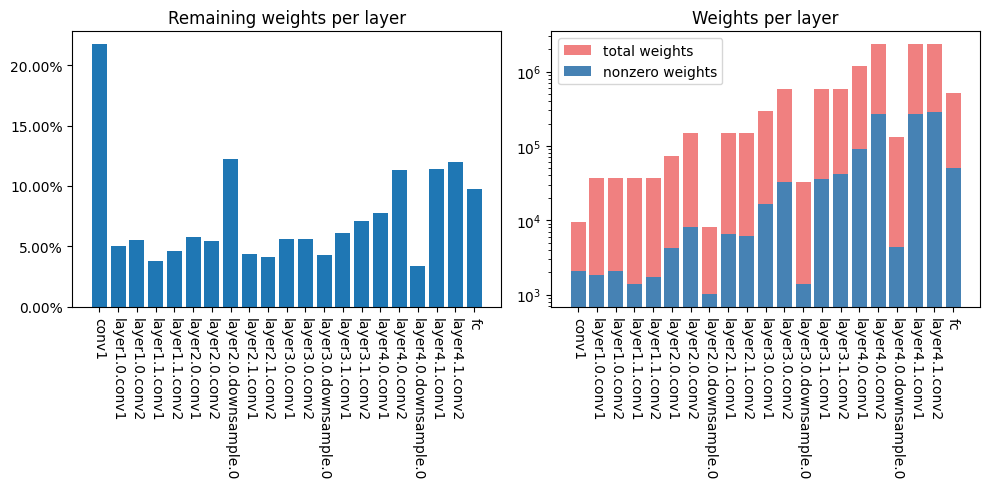

In [6]:
# Plot remaining weights
import numpy as np
import matplotlib.pyplot as plt

names = []
remaining = []
total_w = []
nonzeros = []
for n, m in model.named_modules():
    if isinstance(m, (torch.nn.Conv1d, torch.nn.Conv2d, torch.nn.Linear)):
        names.append(n)
        nonzero = np.count_nonzero(m.weight.detach().cpu())
        remaining_pct = nonzero / m.weight.numel()
        remaining.append(remaining_pct)
        total_w.append(m.weight.numel())
        nonzeros.append(nonzero)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(range(len(names)), remaining)
ax[0].set_xticks(range(len(names)))
ax[0].set_xticklabels(names)
ax[0].tick_params(axis='x', labelrotation=270)
new_ytick = []
for i in ax[0].get_yticklabels():
    ytick = f"{float(i.get_text()) * 100:.2f}%"
    new_ytick.append(ytick)
ax[0].set_yticklabels(new_ytick)
ax[0].title.set_text("Remaining weights per layer")

ax[1].bar(range(len(nonzeros)), total_w, color="lightcoral", label="total weights")
ax[1].bar(range(len(nonzeros)), nonzeros, color="steelblue", label="nonzero weights")
ax[1].set_xticks(range(len(names)))
ax[1].set_xticklabels(names)
ax[1].tick_params(axis='x', labelrotation=270)
ax[1].title.set_text("Weights per layer")
ax[1].legend()
ax[1].set_yscale("log")

plt.tight_layout()
plt.show()

In [ ]:
from keras import ops
def extract_conv_patterns(model):
    """
    Extracts unique 2D binary patterns and their counts from the
    convolutional layers of a given model.
    """
    patterns_by_layer = {}
    backend = keras.backend.backend()

    # Ensure model is on CPU for easier processing
    if backend == "torch":
        modules = model.cpu().named_modules()
    else:
        modules = [(layer.name, layer) for layer in model.layers]

    for name, module in modules:
        is_conv_layer = False
        weight = None
        if backend == "torch" and isinstance(module, torch.nn.Conv2d):
            if hasattr(module, 'weight') and module.weight is not None:
                weight = module.weight.detach()
                is_conv_layer = len(weight.shape) == 4
        elif backend == "tensorflow" and isinstance(module, keras.layers.Conv2D):
            weight = module.kernel
            is_conv_layer = True

        if is_conv_layer:
            out_channels, in_channels, kernel_h, kernel_w = weight.shape

            all_patterns_flat = ops.reshape(weight, (out_channels * in_channels, kernel_h * kernel_w))

            all_patterns_binary = ops.cast(all_patterns_flat > 0, dtype="float32")

            num_bits = all_patterns_binary.shape[1]
            if num_bits == 0:
                continue

            powers_of_2 = ops.power(2.0, ops.arange(num_bits, dtype="float32"))
            hashes = ops.sum(all_patterns_binary * powers_of_2, axis=1)

            unique_hashes, counts = np.unique(keras.ops.convert_to_numpy(hashes), return_counts=True)

            # Cast to integer for bitwise operation
            unique_hashes_int = unique_hashes.astype(np.int64)
            unique_patterns_binary = ((unique_hashes_int[:, None] & (1 << np.arange(num_bits))) > 0).astype(float)

            sort_indices = np.argsort(counts)[::-1]
            patterns_by_layer[name] = {
                'patterns': unique_patterns_binary[sort_indices],
                'counts': counts[sort_indices],
                'kernel_shape': (kernel_h, kernel_w) # Shape is now correct for reshaping
            }
            print(f"Processed layer '{name}', found {len(counts)} unique patterns.")

    return patterns_by_layer

In [20]:
import math

def plot_pattern_distribution(layer_name, pattern_data):
    """
    Creates a histogram showing the distribution of pattern frequencies.

    Returns: A matplotlib Figure object for saving.
    """
    counts = pattern_data['counts']
    num_unique_patterns = len(counts)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(range(num_unique_patterns), counts, color='steelblue')
    
    ax.set_title(f"Pattern Distribution for Layer: {layer_name}", fontsize=16)
    ax.set_xlabel("Pattern Index (Sorted by Frequency)")
    ax.set_ylabel("Frequency (Count)")
    ax.set_yscale('log')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    return fig

def plot_dominant_patterns(layer_name, pattern_data, max_patterns_to_show=16):
    """
    Creates a grid visualization of the most dominant binary patterns.

    Returns: A matplotlib Figure object for saving.
    """
    patterns = pattern_data['patterns']
    kernel_h, kernel_w = pattern_data['kernel_shape']
    num_to_show = min(len(patterns), max_patterns_to_show)

    cols = math.ceil(math.sqrt(num_to_show))
    rows = math.ceil(num_to_show / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2.2))
    axes = np.array(axes).flatten()

    fig.suptitle(f"Dominant Patterns for Layer: {layer_name}", fontsize=16)

    for i in range(num_to_show):
        pattern_2d = patterns[i].reshape(kernel_h, kernel_w)
        axes[i].imshow(pattern_2d, cmap='binary', vmin=0, vmax=1, interpolation='nearest')
        axes[i].set_title(f"Pattern #{i+1}\n(Count: {pattern_data['counts'][i]})")
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    # Hide unused subplots
    for j in range(num_to_show, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    return fig

Processed layer 'conv1', found 133 unique patterns.
Processed layer 'layer1.0.conv1', found 97 unique patterns.
Processed layer 'layer1.0.conv2', found 91 unique patterns.
Processed layer 'layer1.1.conv1', found 72 unique patterns.
Processed layer 'layer1.1.conv2', found 76 unique patterns.
Processed layer 'layer2.0.conv1', found 127 unique patterns.
Processed layer 'layer2.0.conv2', found 162 unique patterns.
Processed layer 'layer2.0.downsample.0', found 2 unique patterns.
Processed layer 'layer2.1.conv1', found 108 unique patterns.
Processed layer 'layer2.1.conv2', found 130 unique patterns.
Processed layer 'layer3.0.conv1', found 186 unique patterns.
Processed layer 'layer3.0.conv2', found 94 unique patterns.
Processed layer 'layer3.0.downsample.0', found 2 unique patterns.
Processed layer 'layer3.1.conv1', found 117 unique patterns.
Processed layer 'layer3.1.conv2', found 100 unique patterns.
Processed layer 'layer4.0.conv1', found 107 unique patterns.
Processed layer 'layer4.0.co

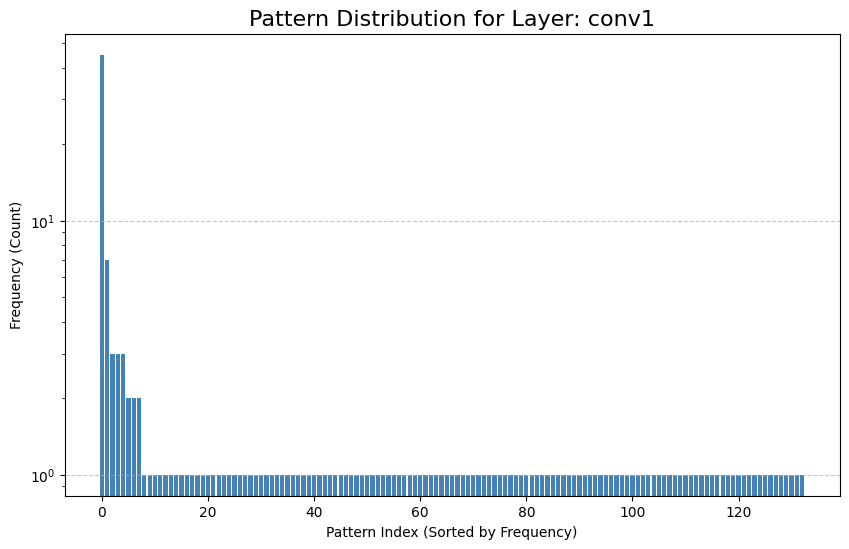

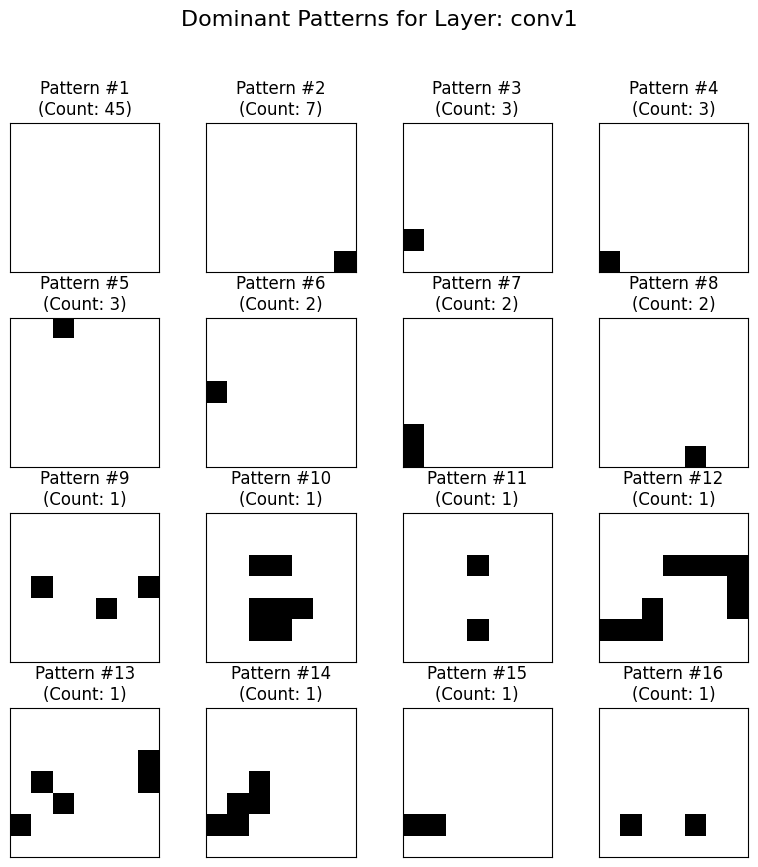

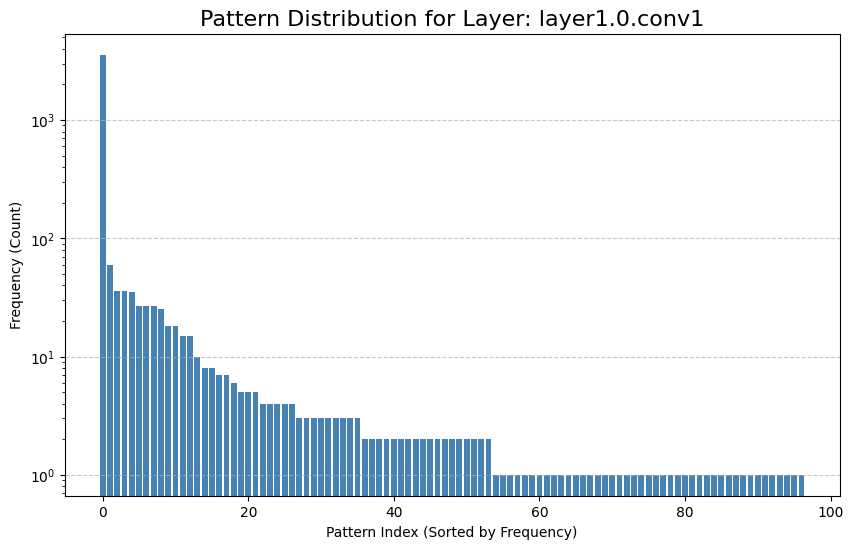

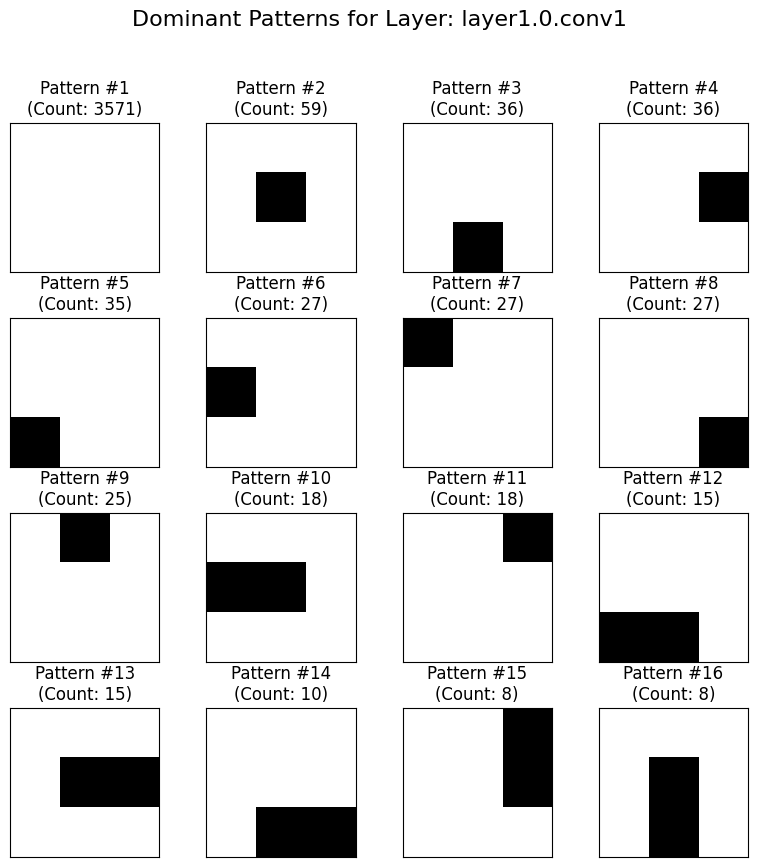

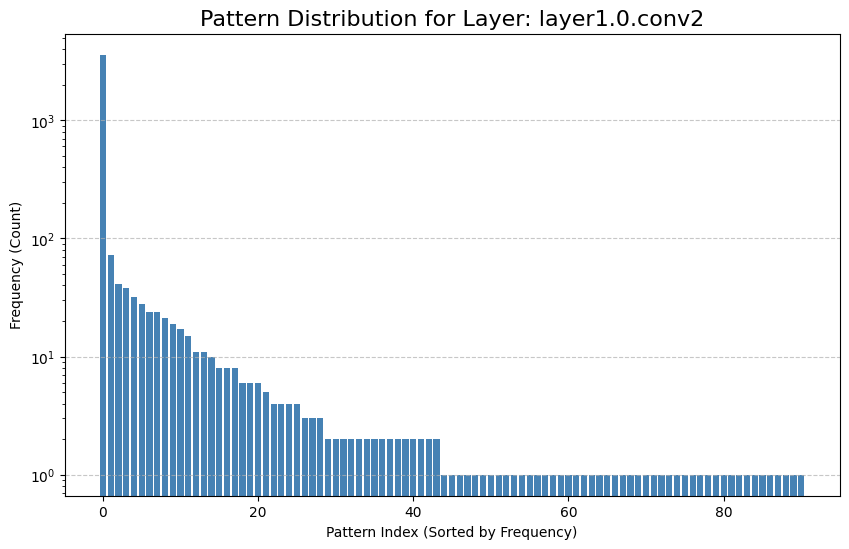

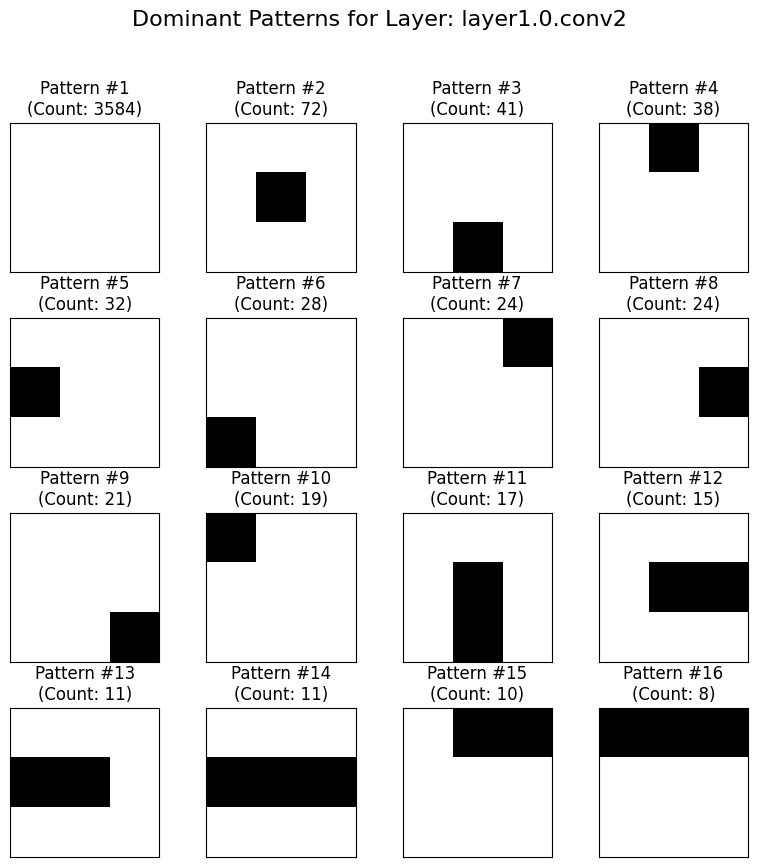

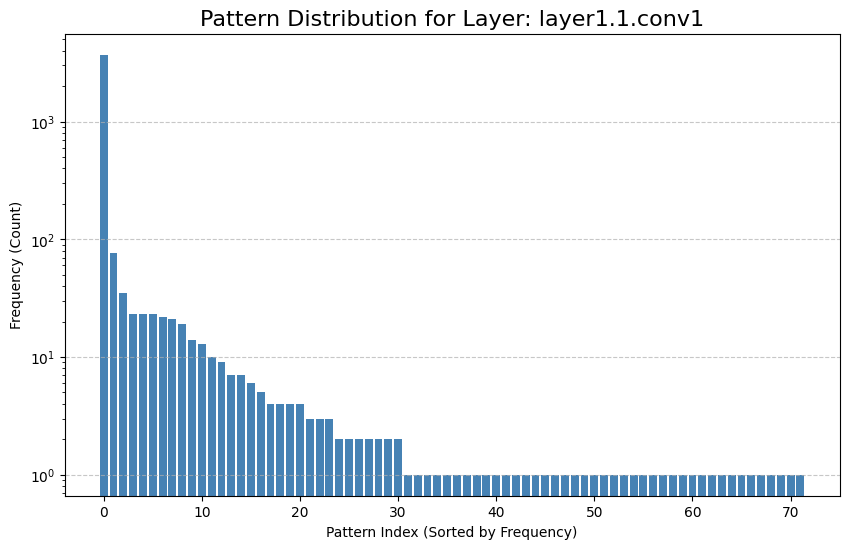

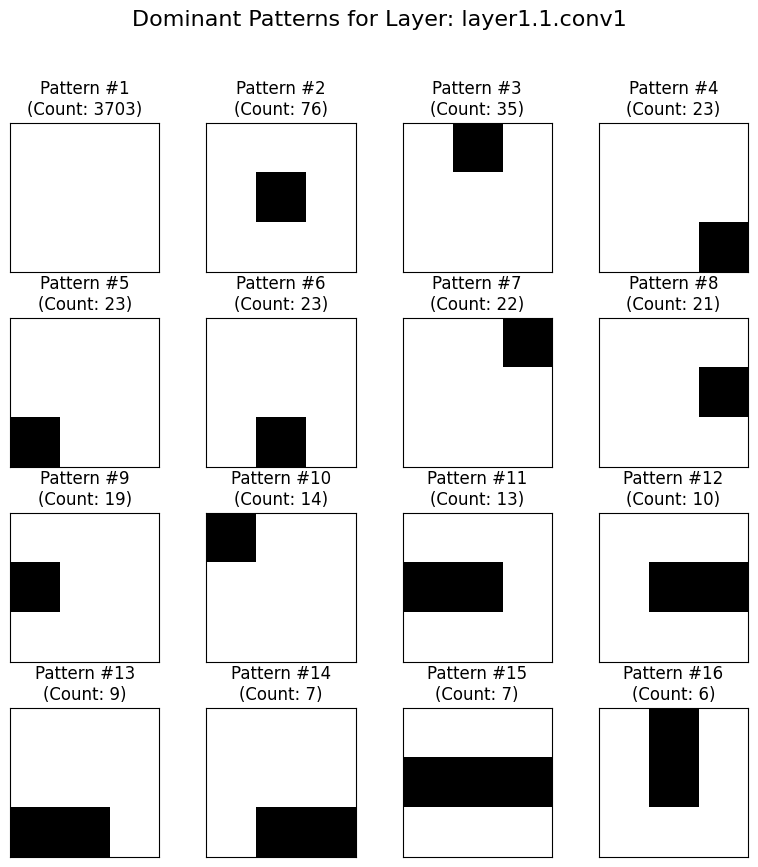

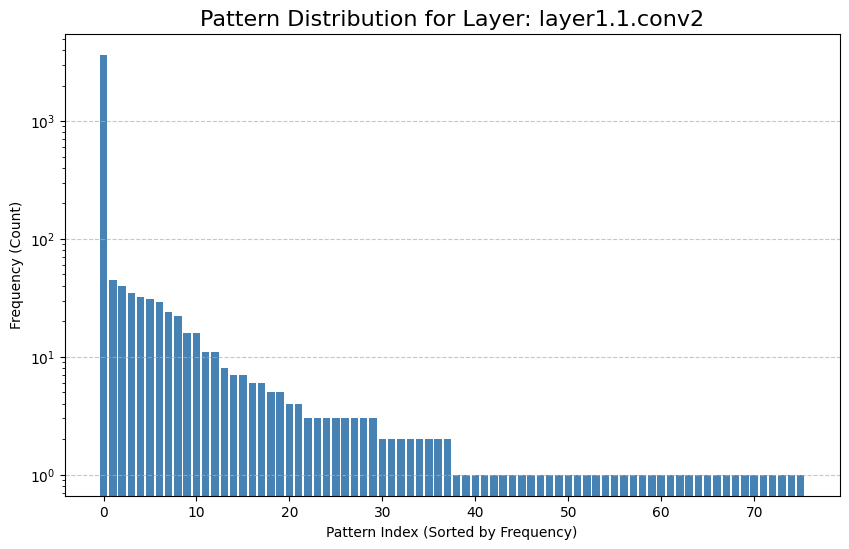

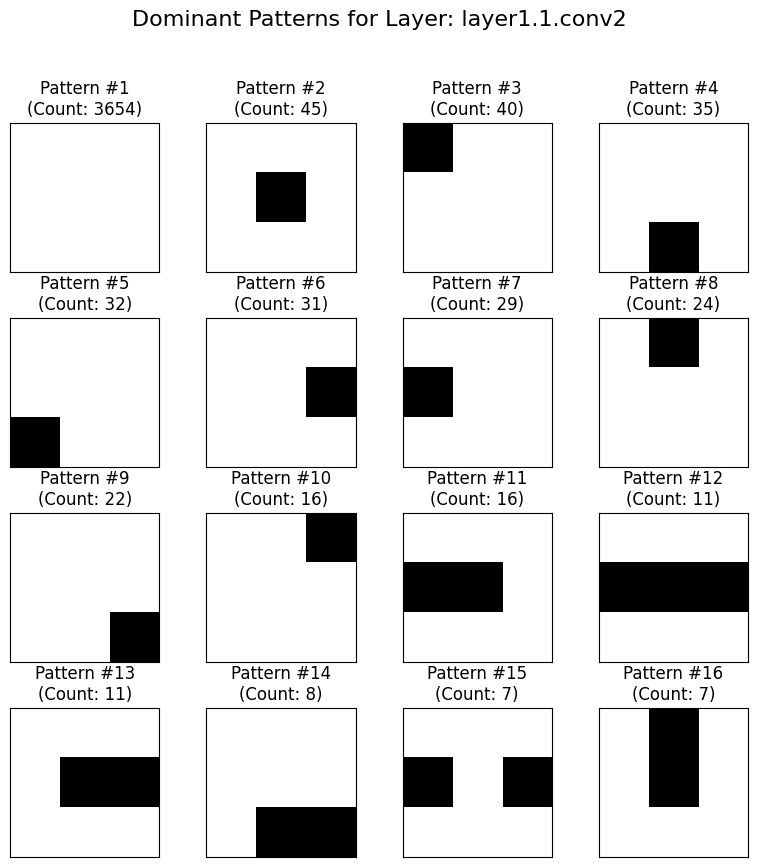

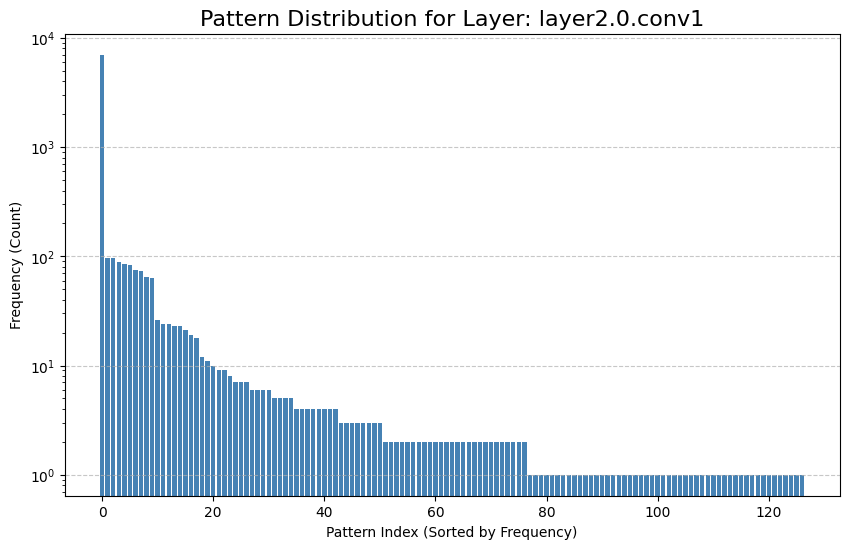

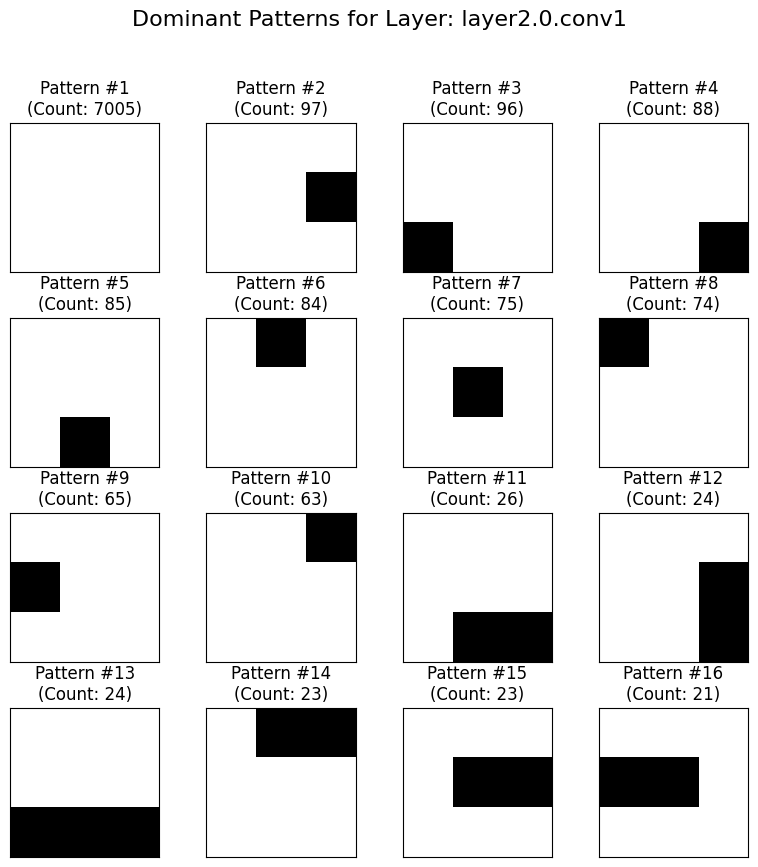

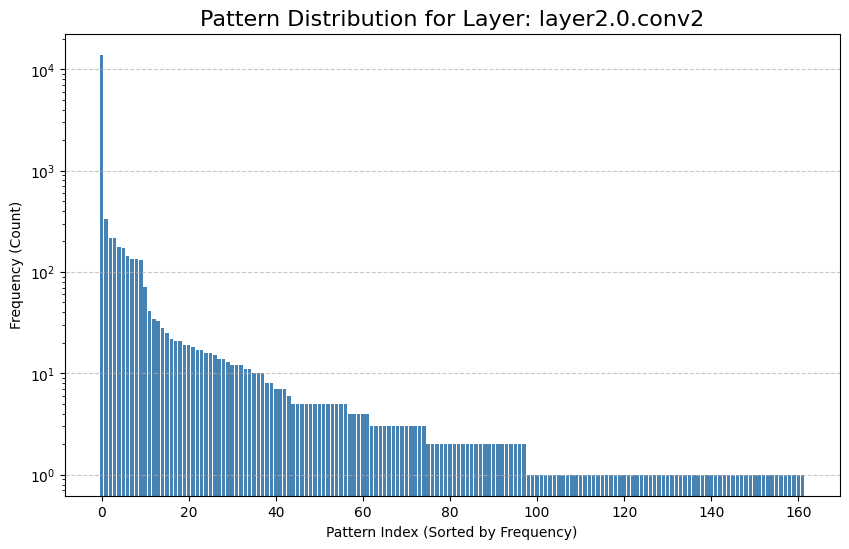

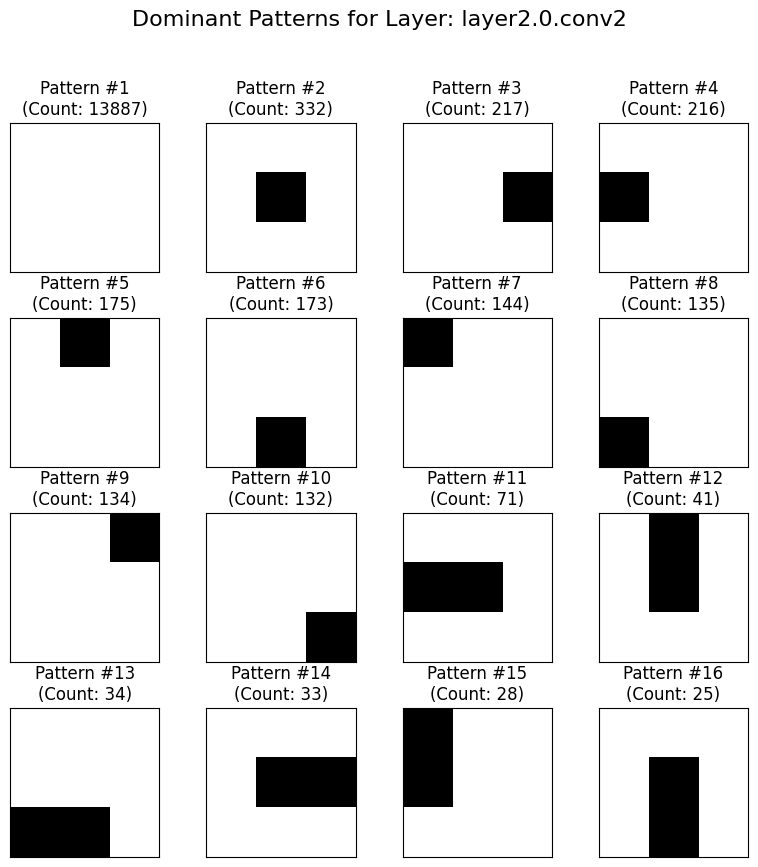

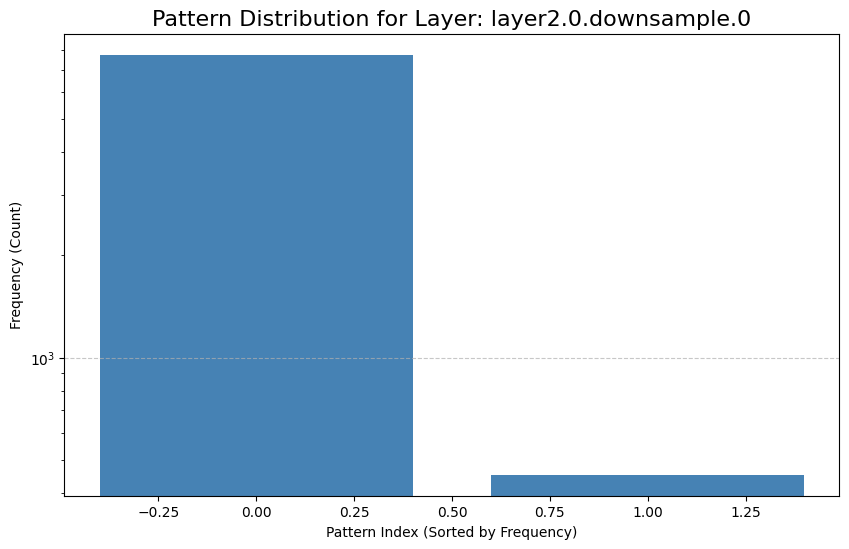

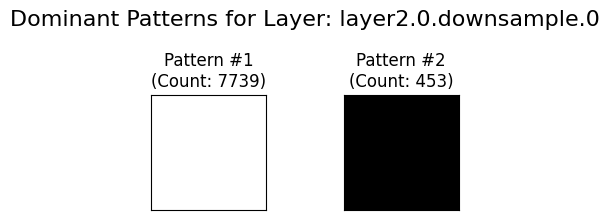

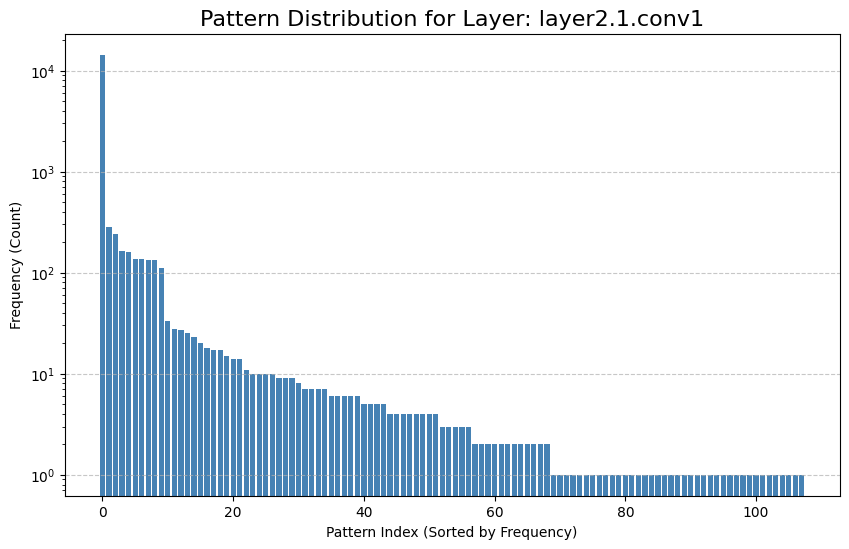

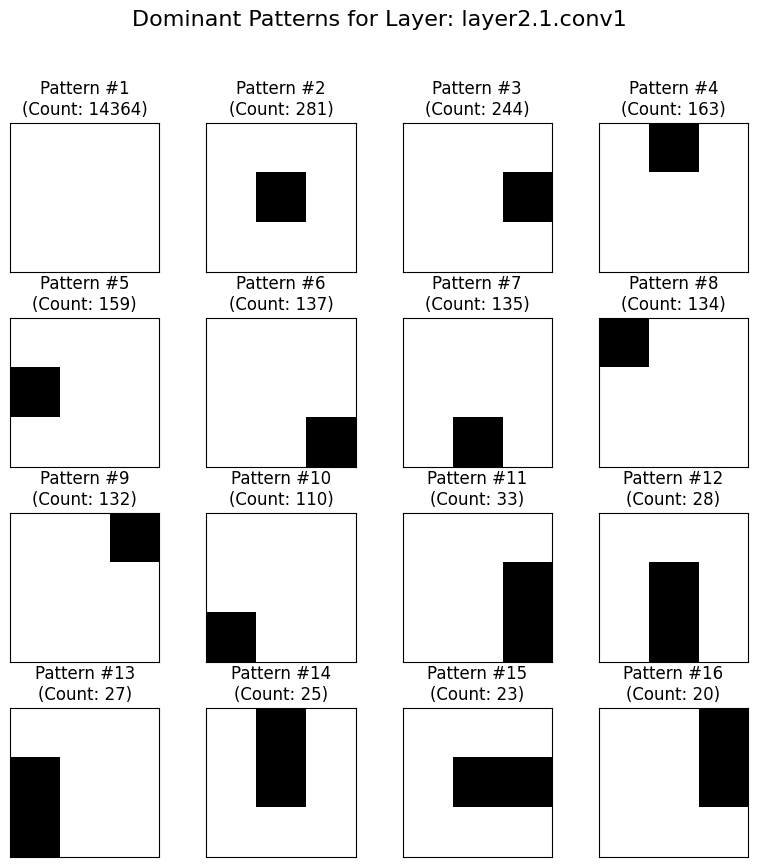

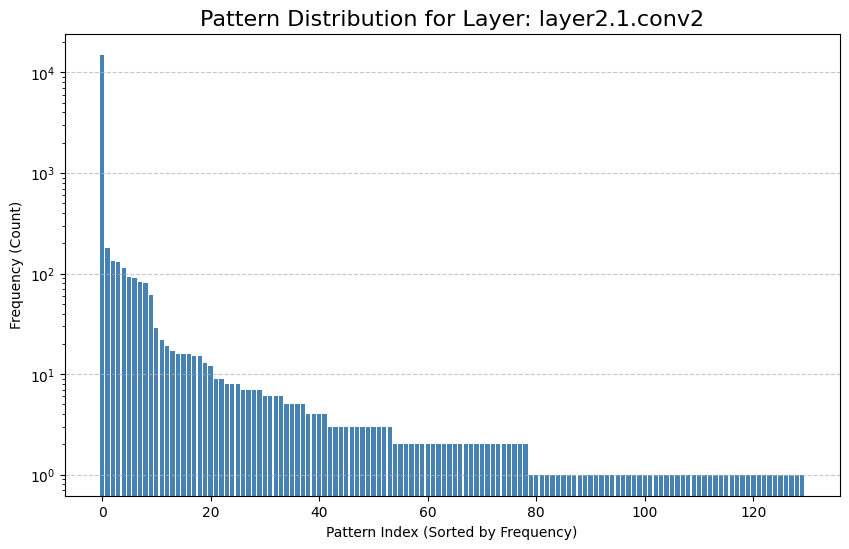

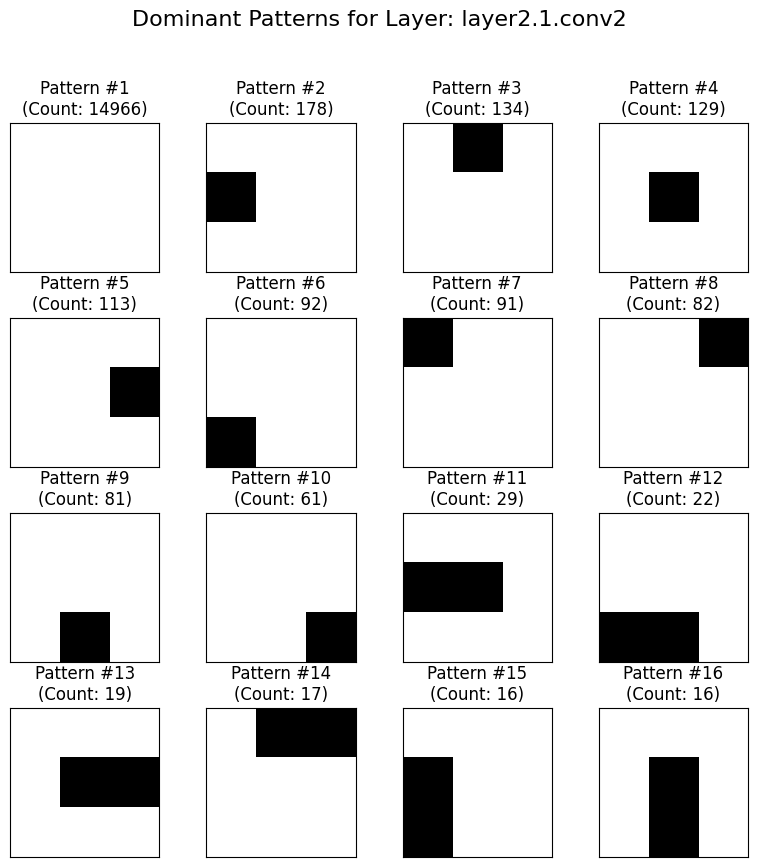

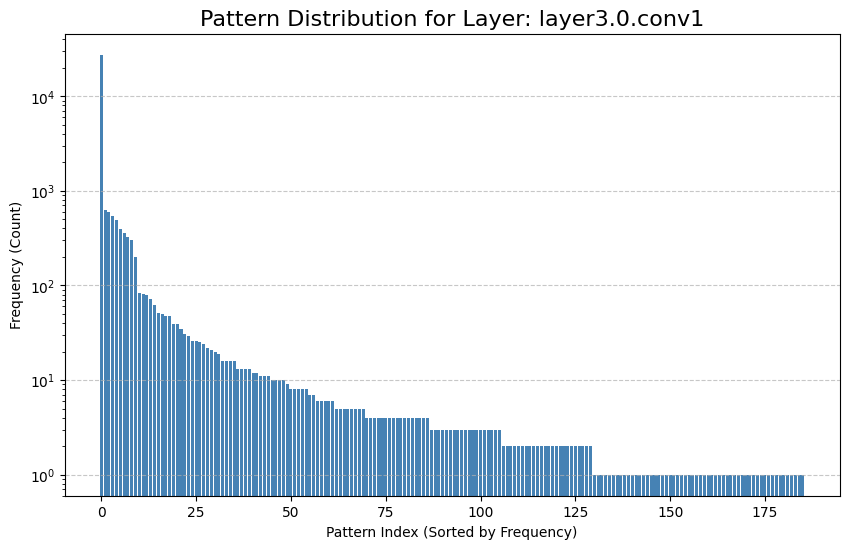

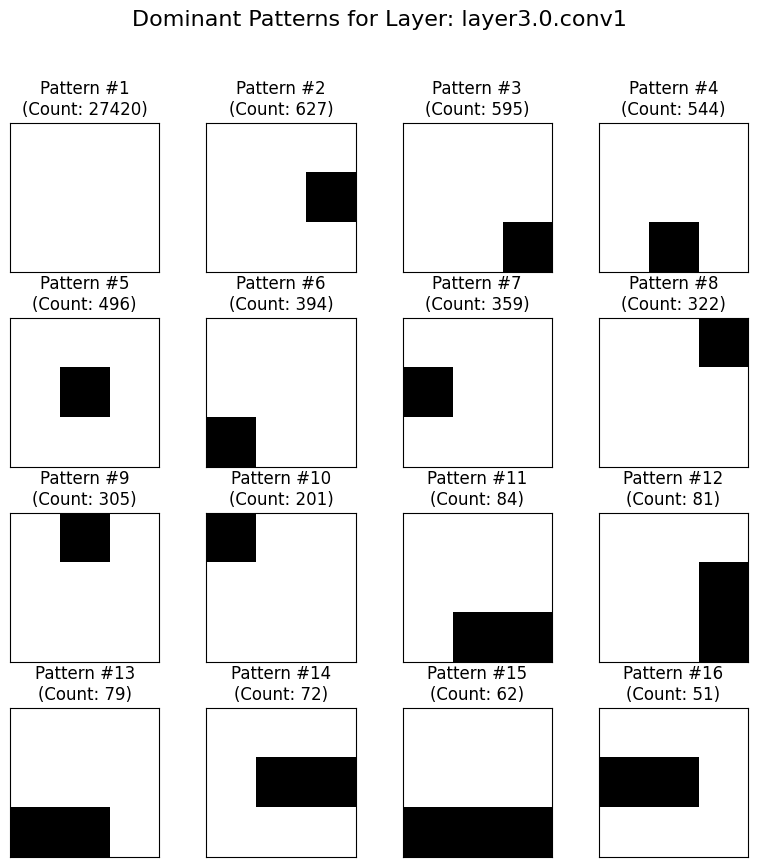

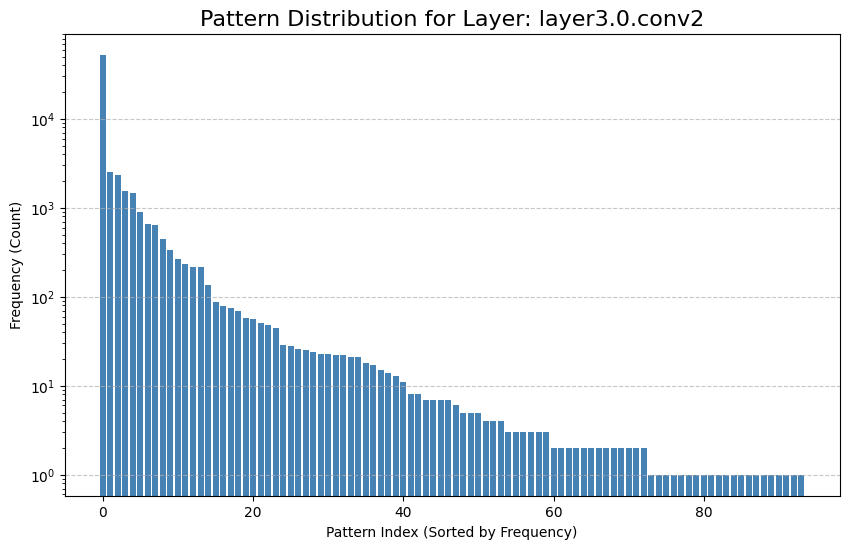

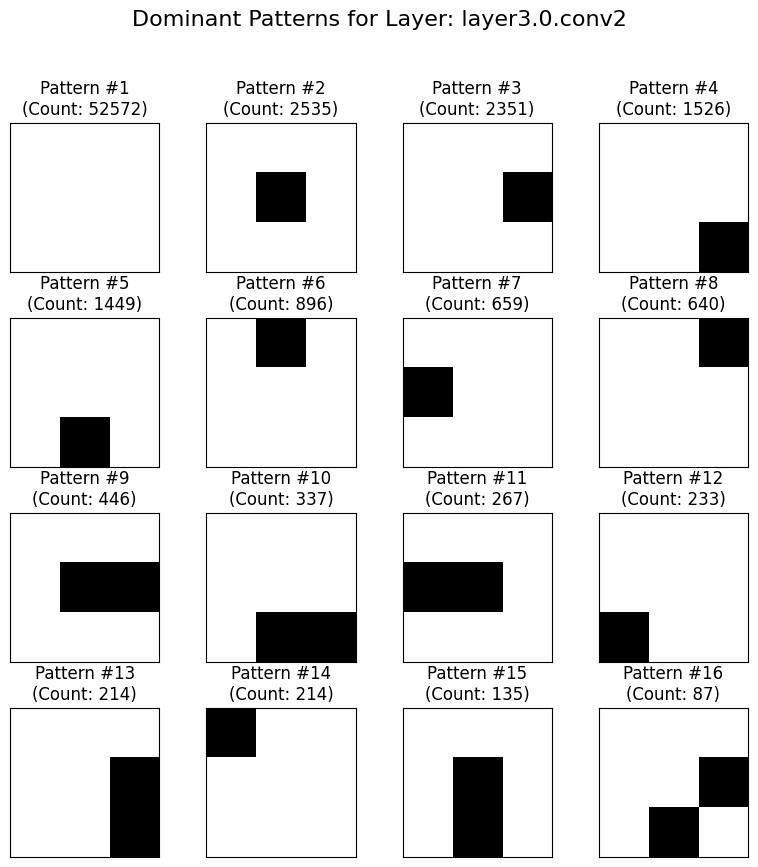

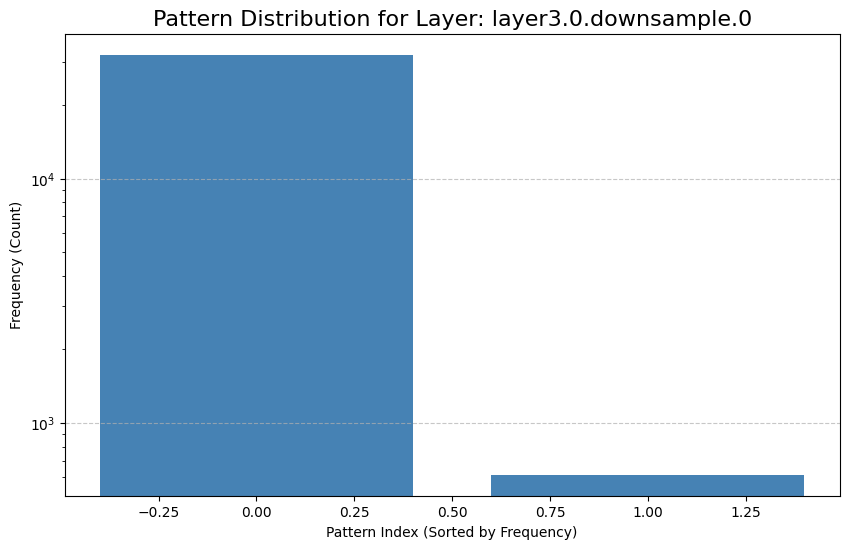

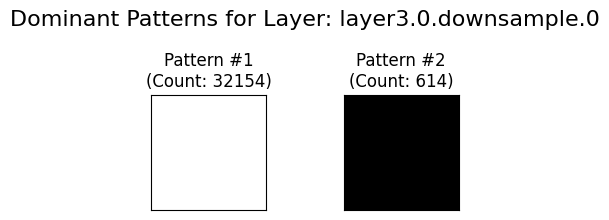

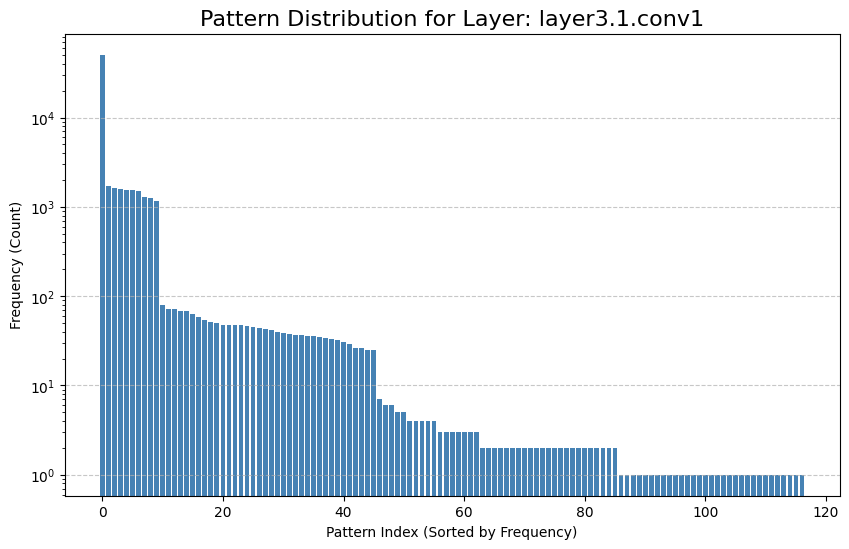

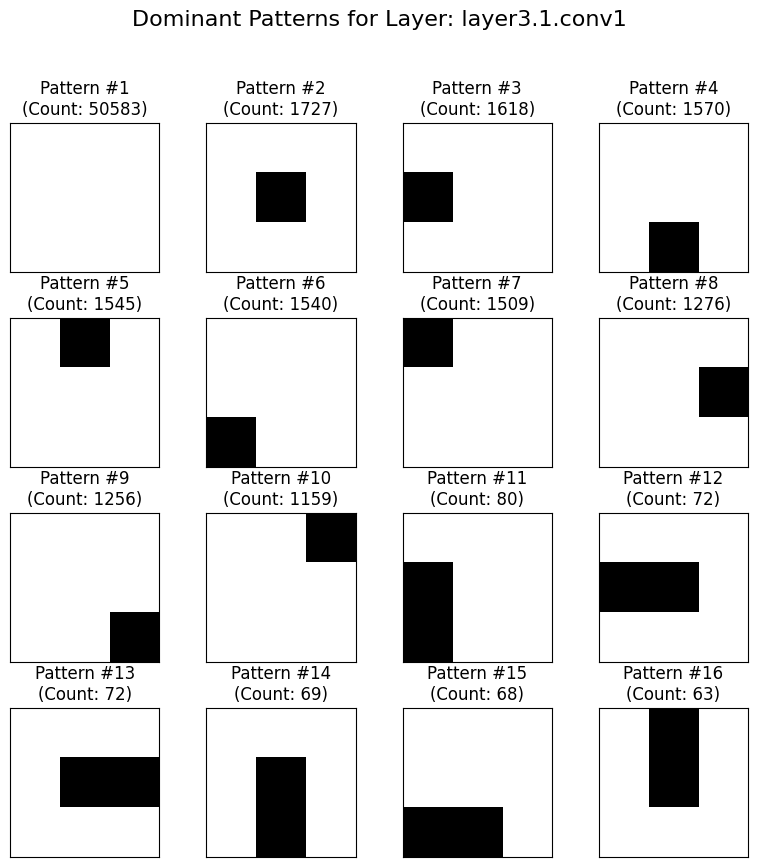

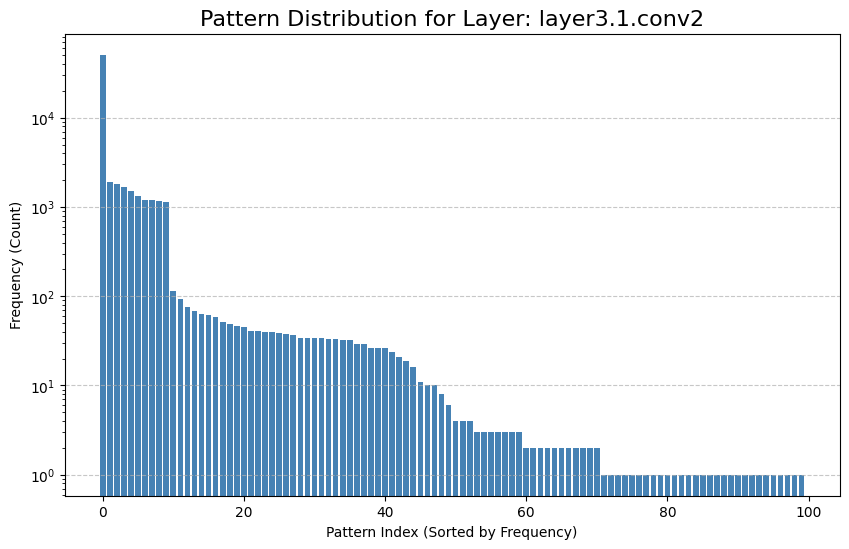

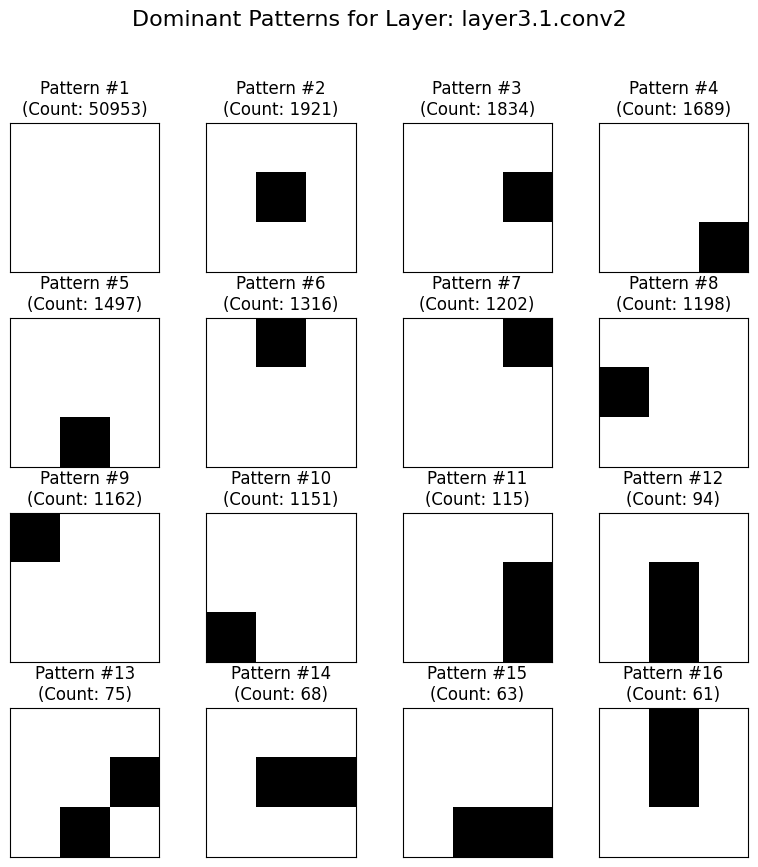

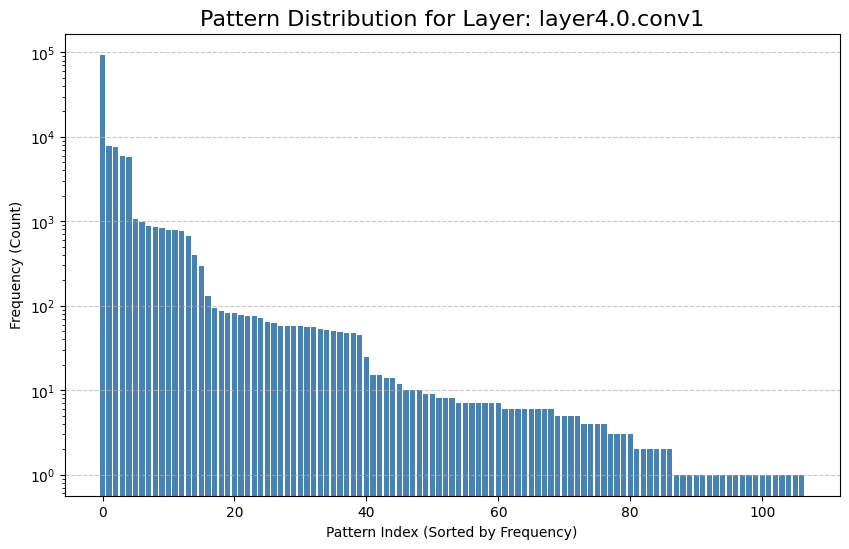

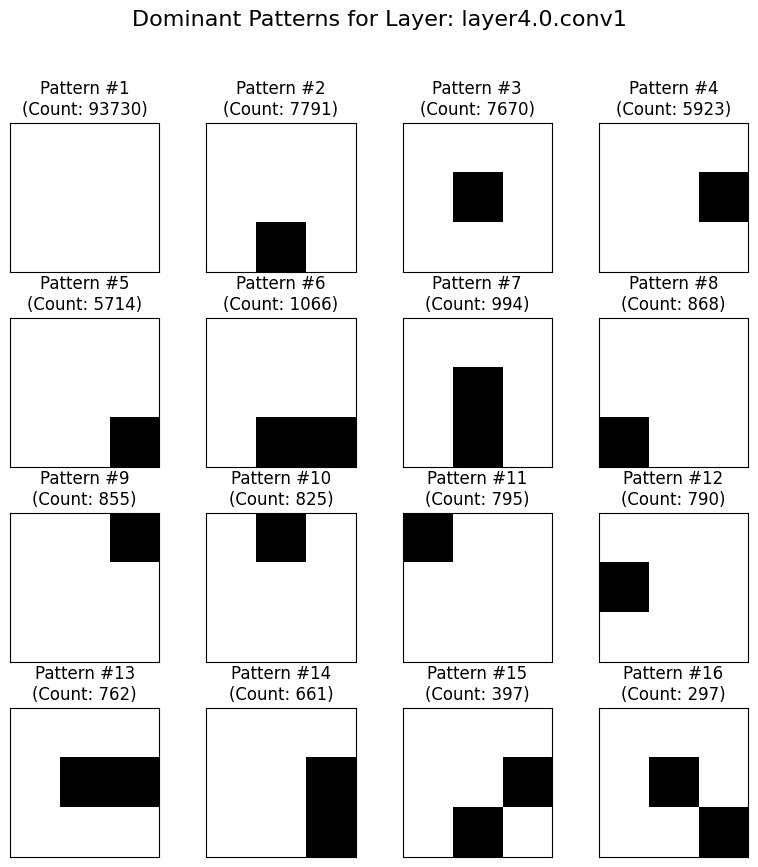

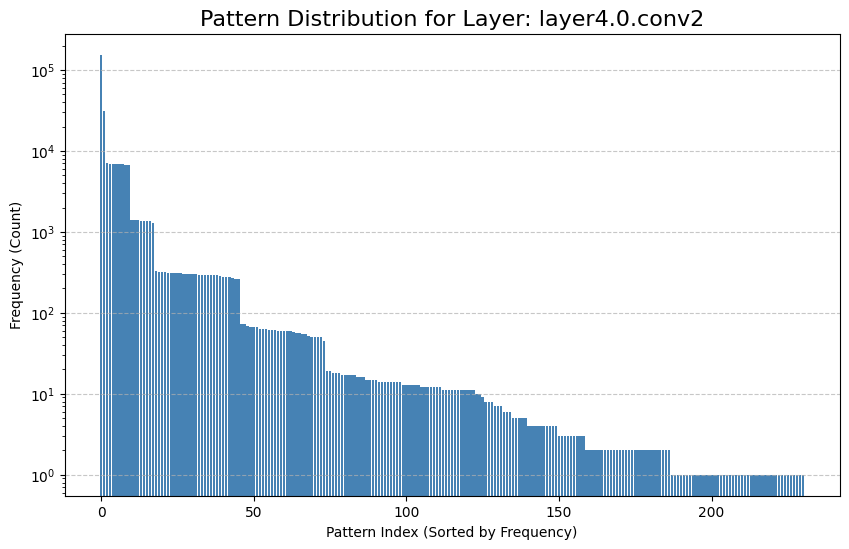

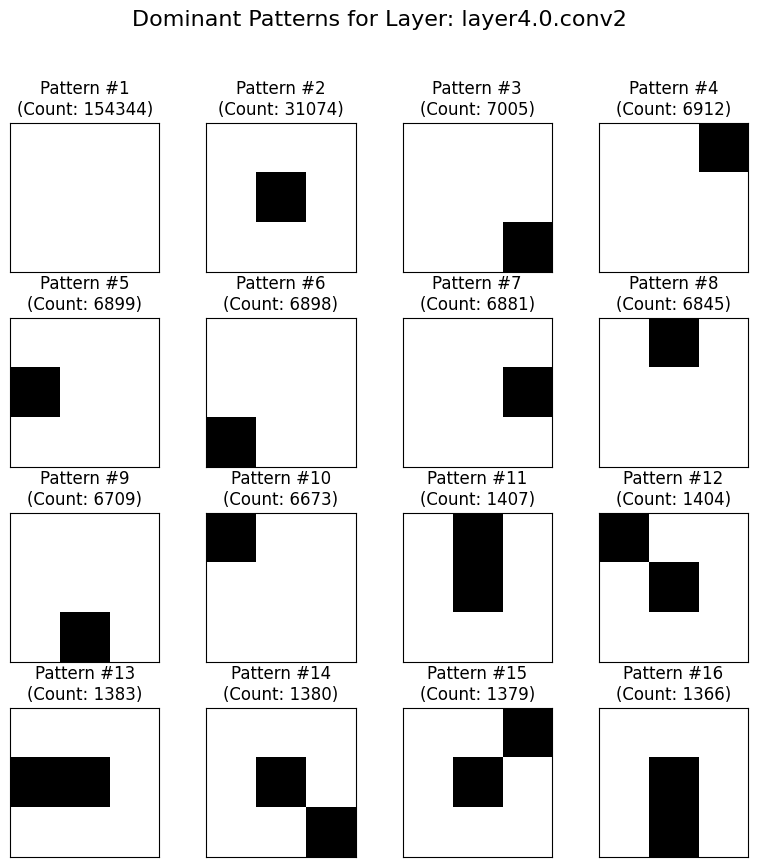

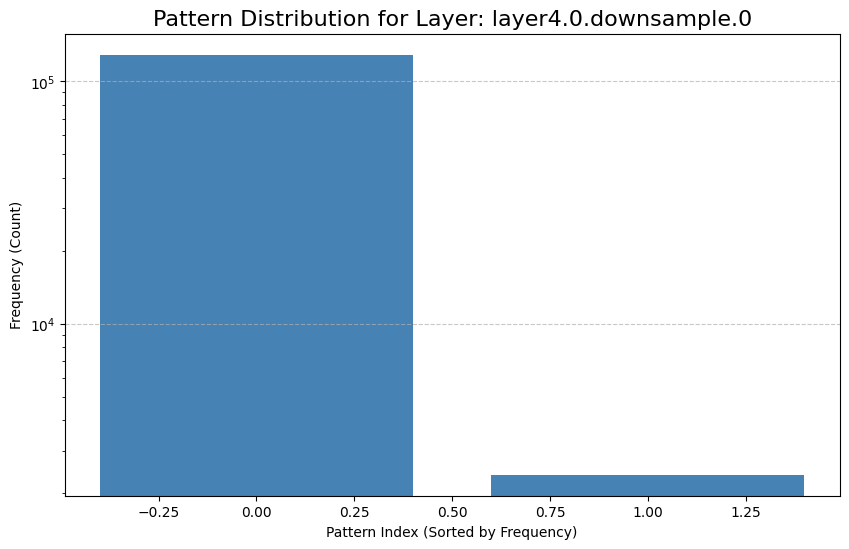

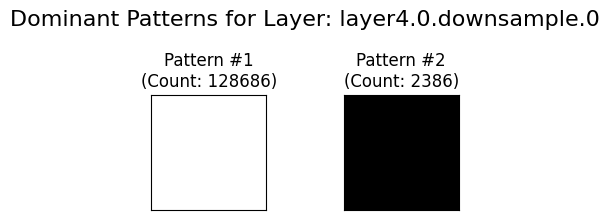

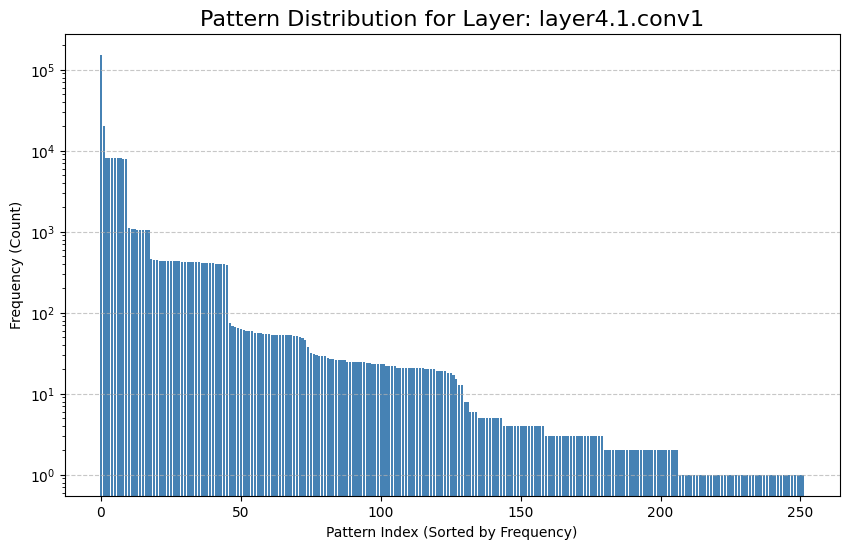

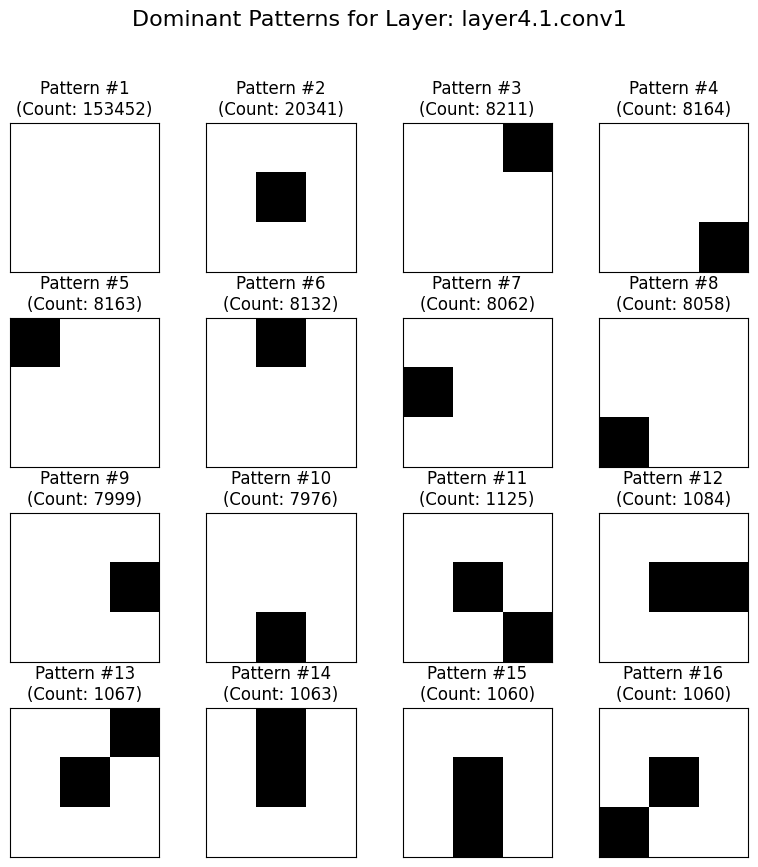

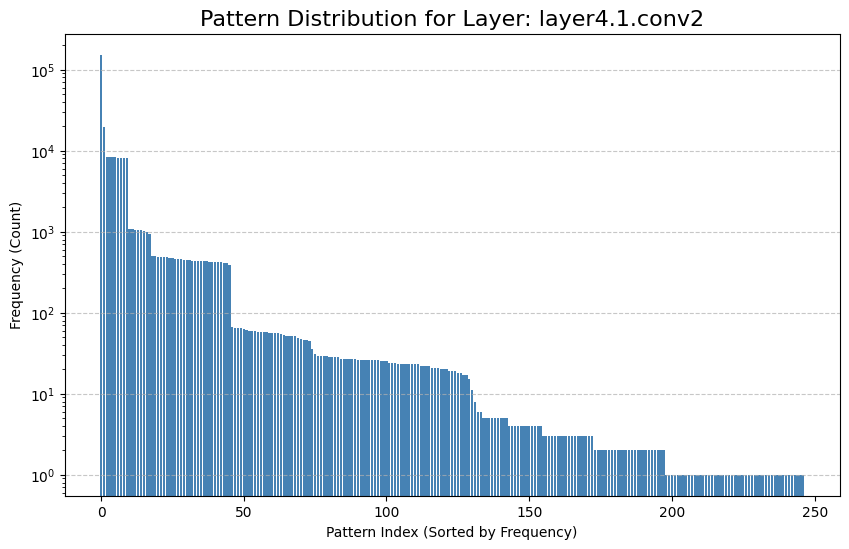

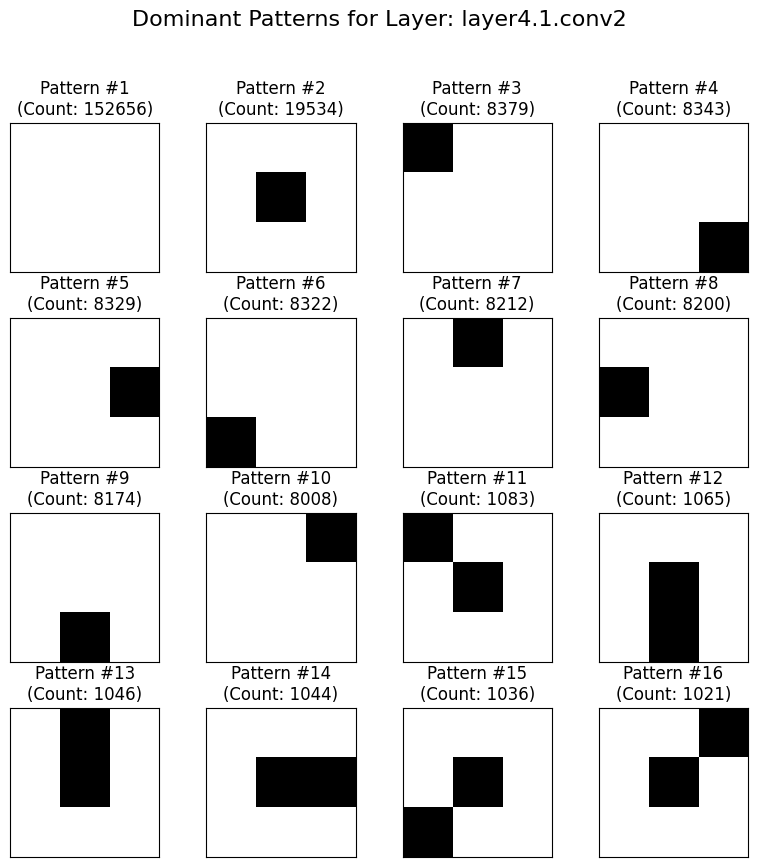

In [21]:
all_patterns = extract_conv_patterns(model)
for layer_name, data in all_patterns.items():
    fig_hist = plot_pattern_distribution(layer_name, data)
    plt.show()
    
    fig_patterns = plot_dominant_patterns(layer_name, data)
    plt.show()

In [25]:
SAVE_PATH = 'resnet_mdmm_unstr_paca_pruned.pth'

model_paca = torchvision.models.resnet18()
model_paca.load_state_dict(torch.load(SAVE_PATH))

<All keys matched successfully>

In [27]:
all_patterns = extract_conv_patterns(model_paca)


Processed layer 'conv1', found 8 unique patterns.
Processed layer 'layer1.0.conv1', found 5 unique patterns.
Processed layer 'layer1.0.conv2', found 1 unique patterns.
Processed layer 'layer1.1.conv1', found 3 unique patterns.
Processed layer 'layer1.1.conv2', found 4 unique patterns.
Processed layer 'layer2.0.conv1', found 1 unique patterns.
Processed layer 'layer2.0.conv2', found 1 unique patterns.
Processed layer 'layer2.0.downsample.0', found 1 unique patterns.
Processed layer 'layer2.1.conv1', found 4 unique patterns.
Processed layer 'layer2.1.conv2', found 3 unique patterns.
Processed layer 'layer3.0.conv1', found 4 unique patterns.
Processed layer 'layer3.0.conv2', found 3 unique patterns.
Processed layer 'layer3.0.downsample.0', found 1 unique patterns.
Processed layer 'layer3.1.conv1', found 10 unique patterns.
Processed layer 'layer3.1.conv2', found 10 unique patterns.
Processed layer 'layer4.0.conv1', found 10 unique patterns.
Processed layer 'layer4.0.conv2', found 130 uniq

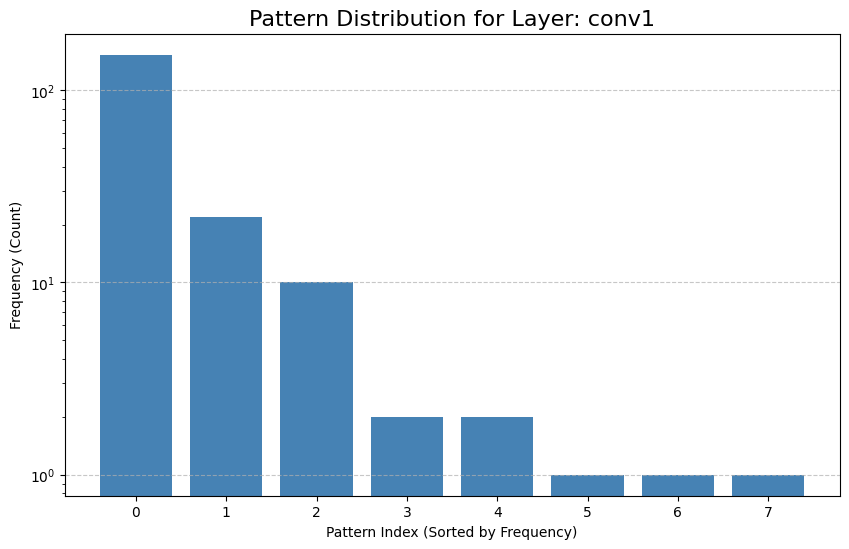

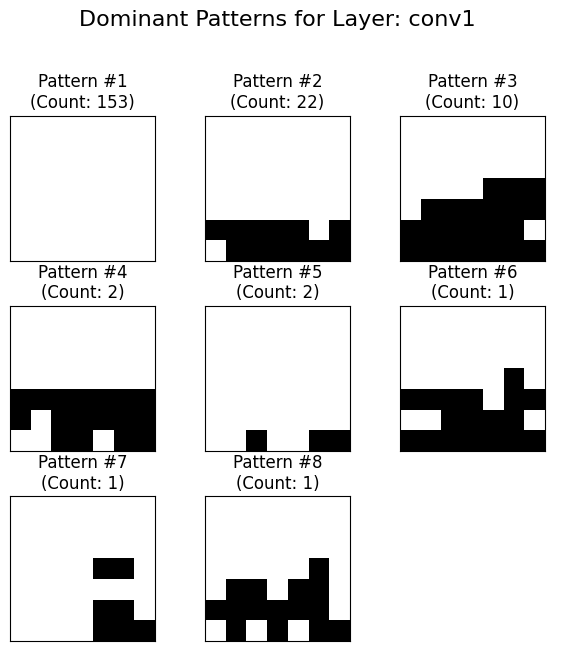

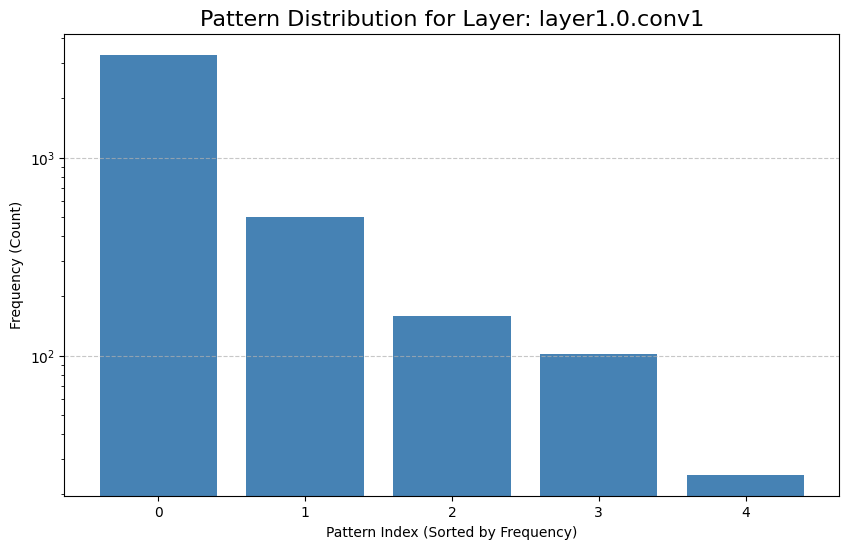

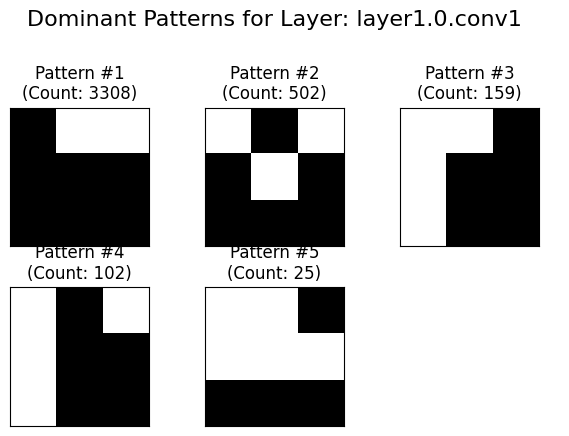

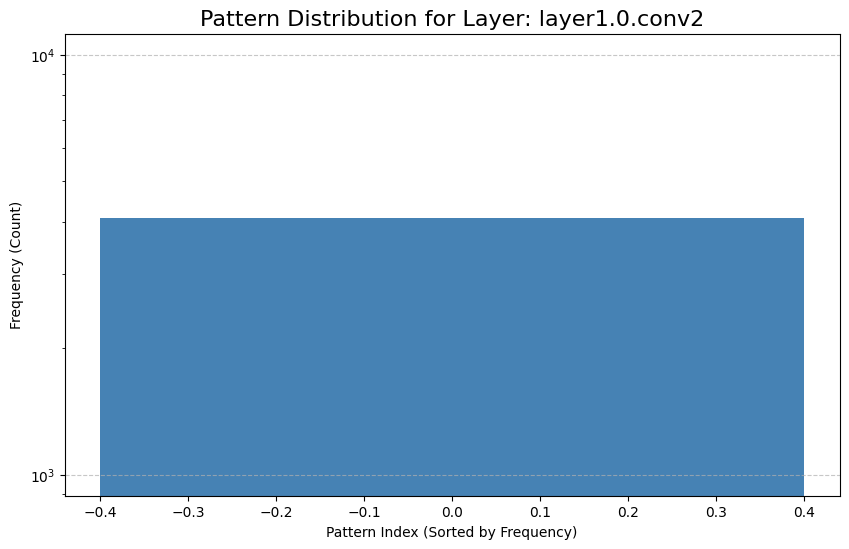

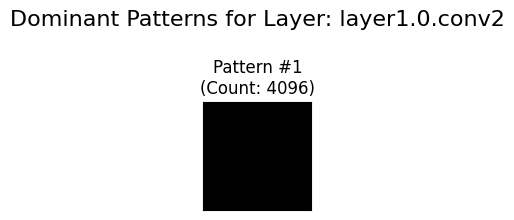

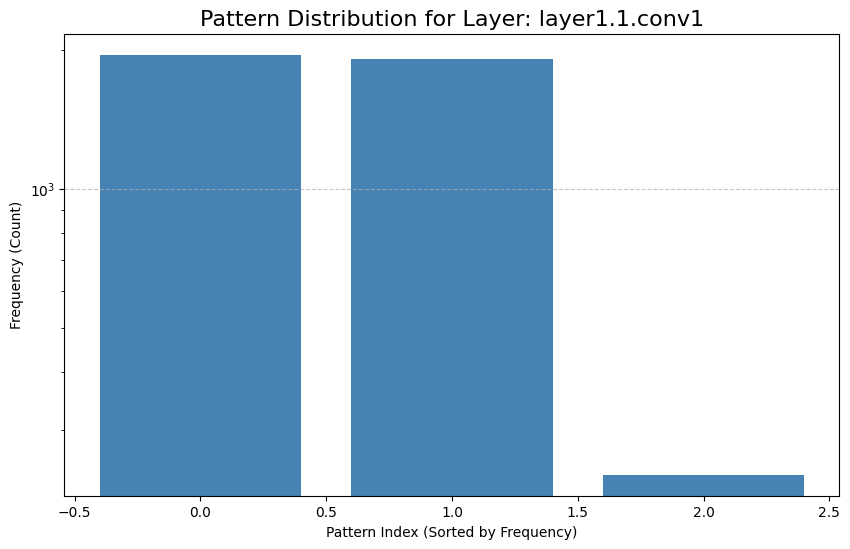

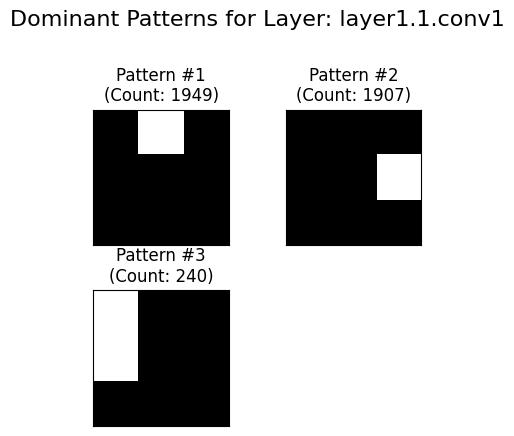

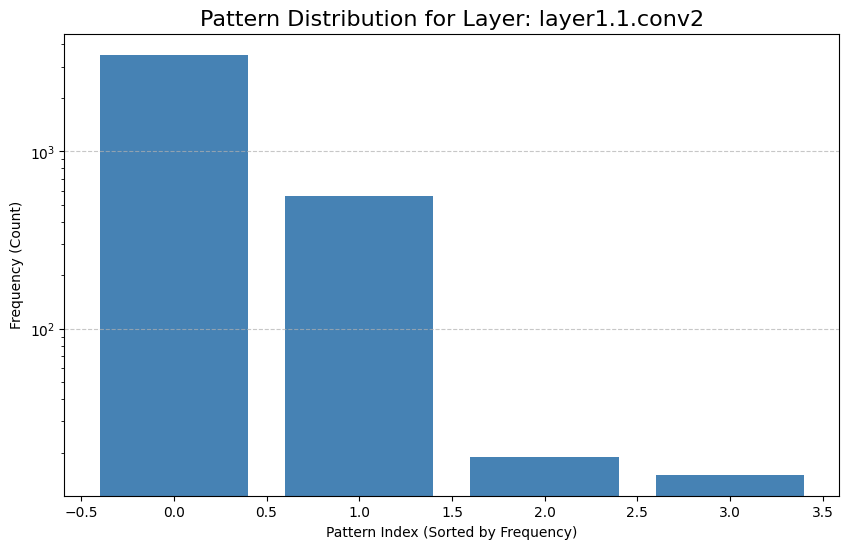

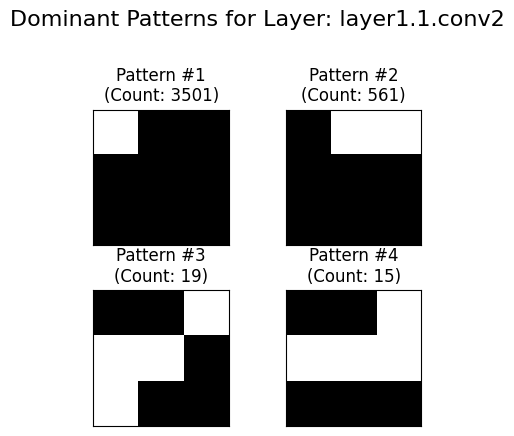

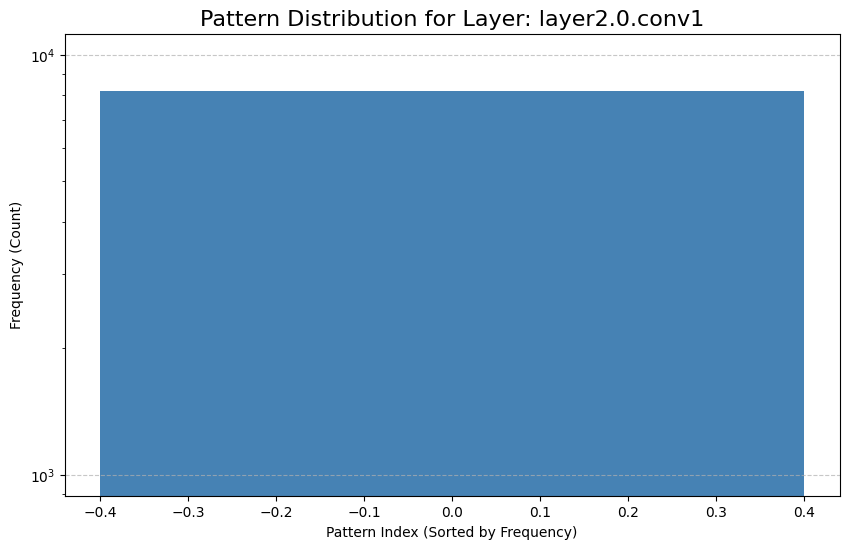

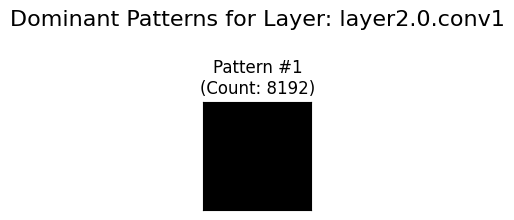

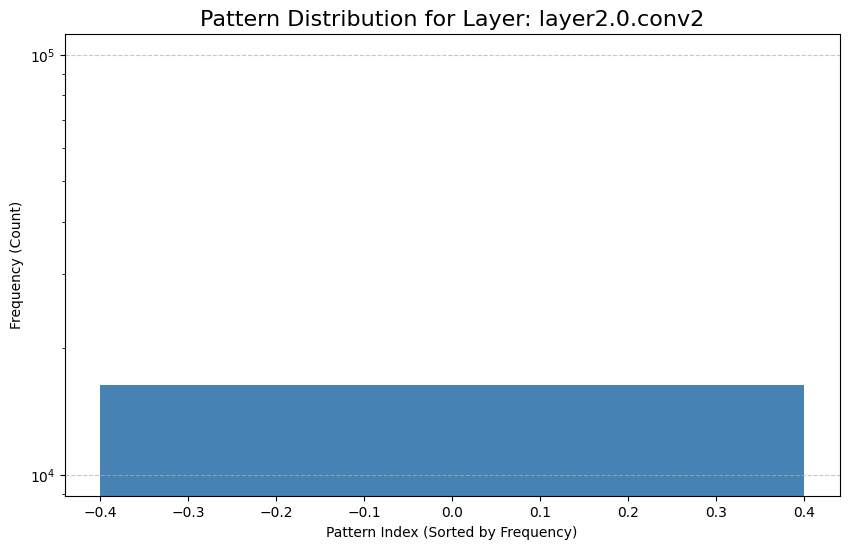

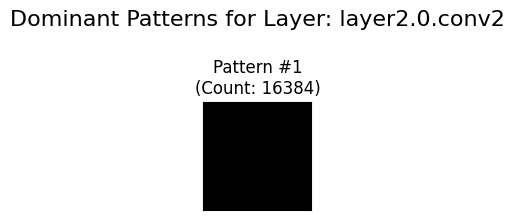

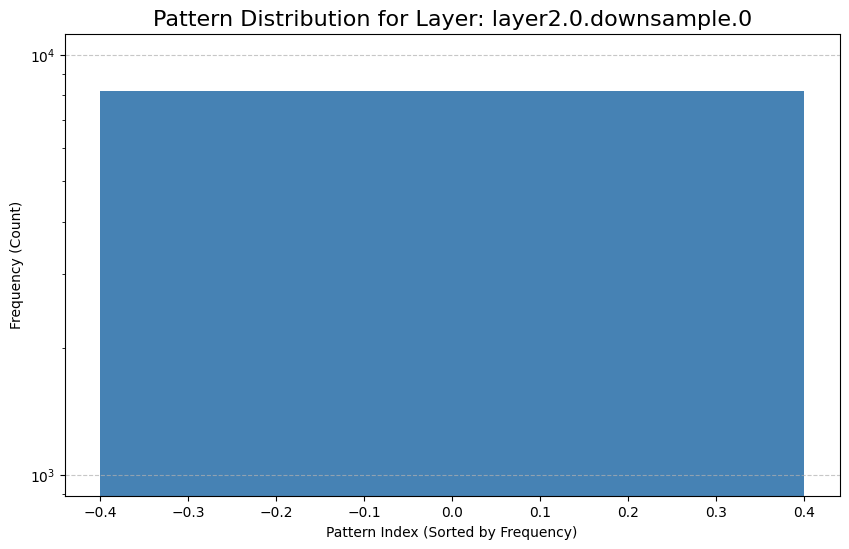

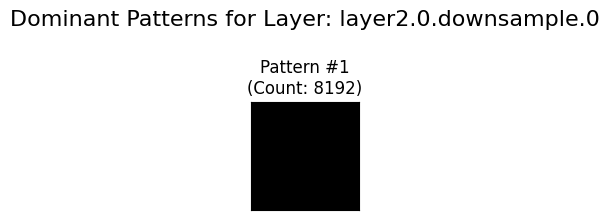

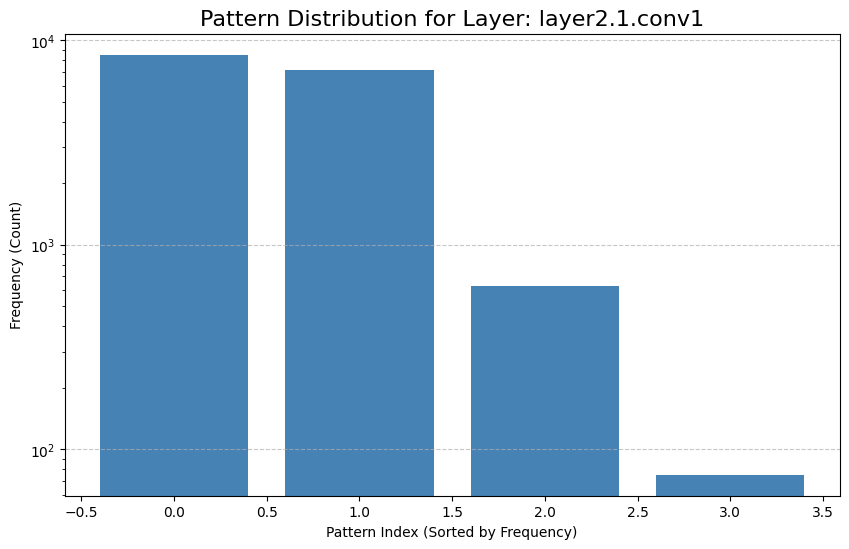

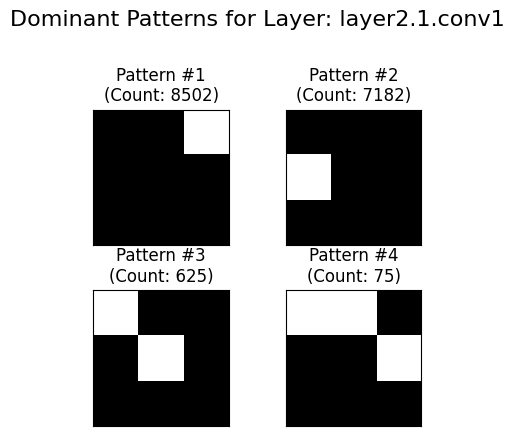

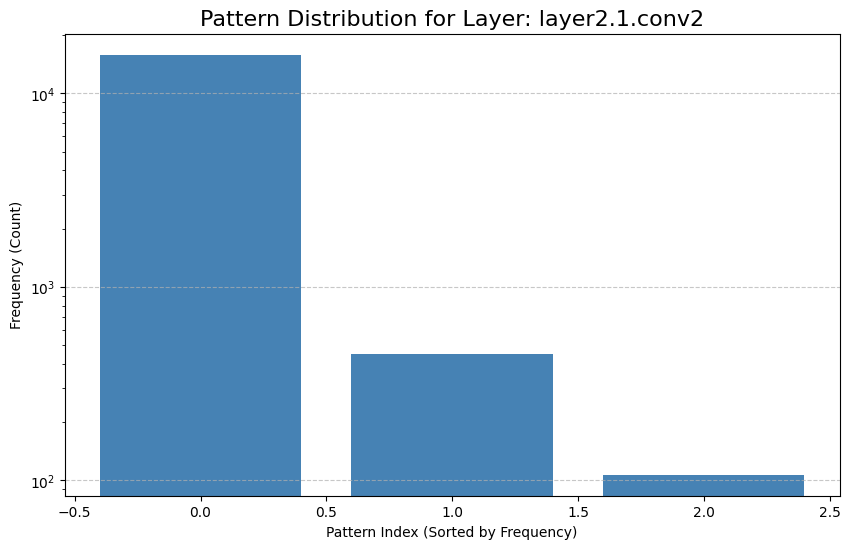

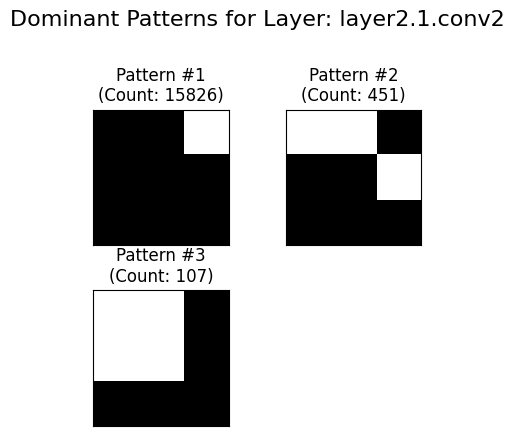

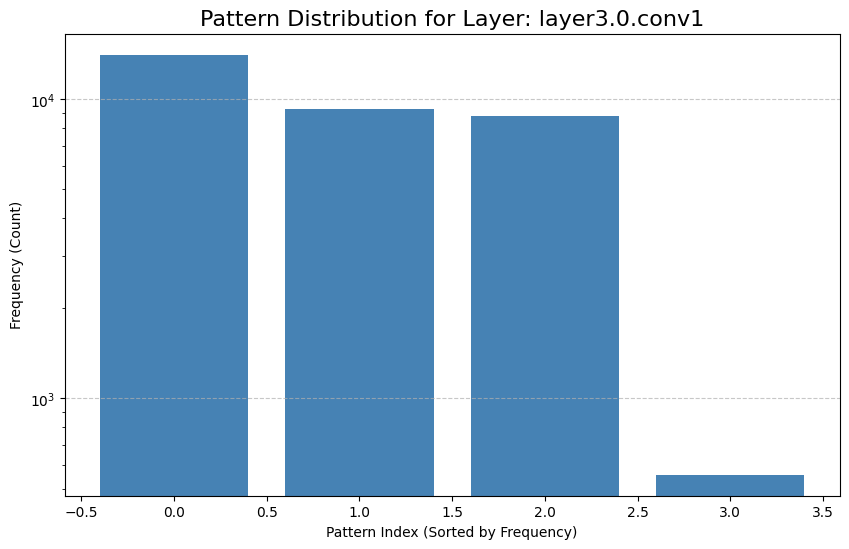

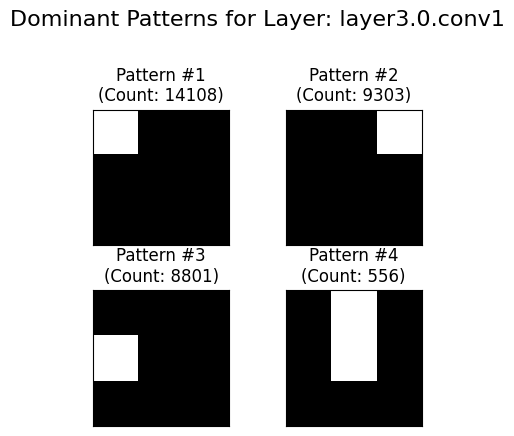

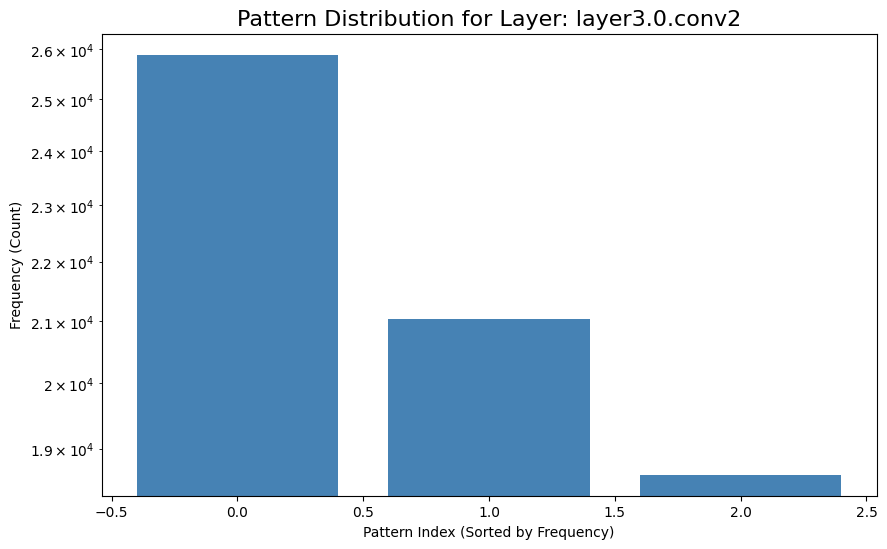

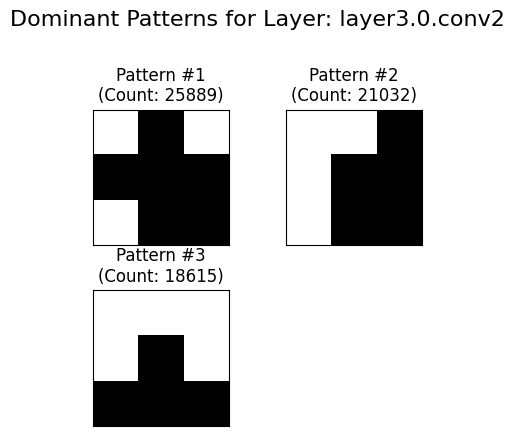

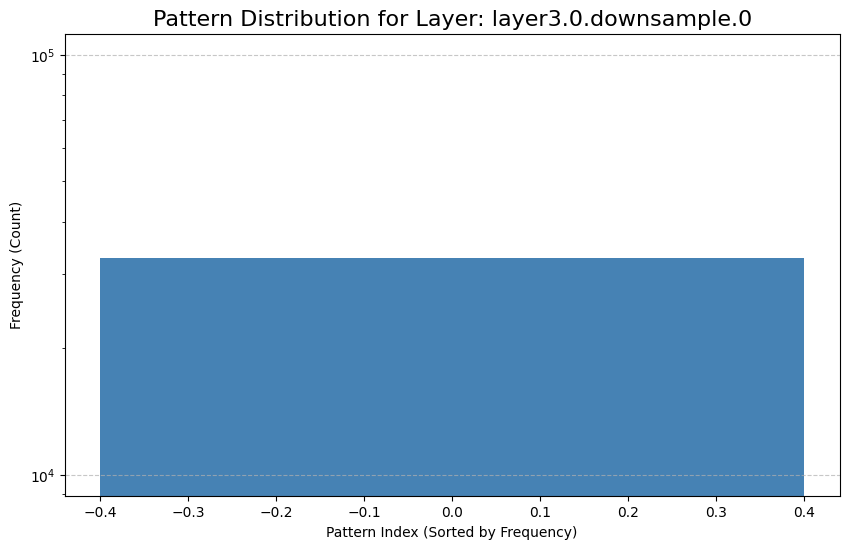

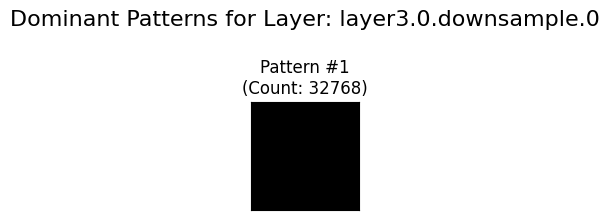

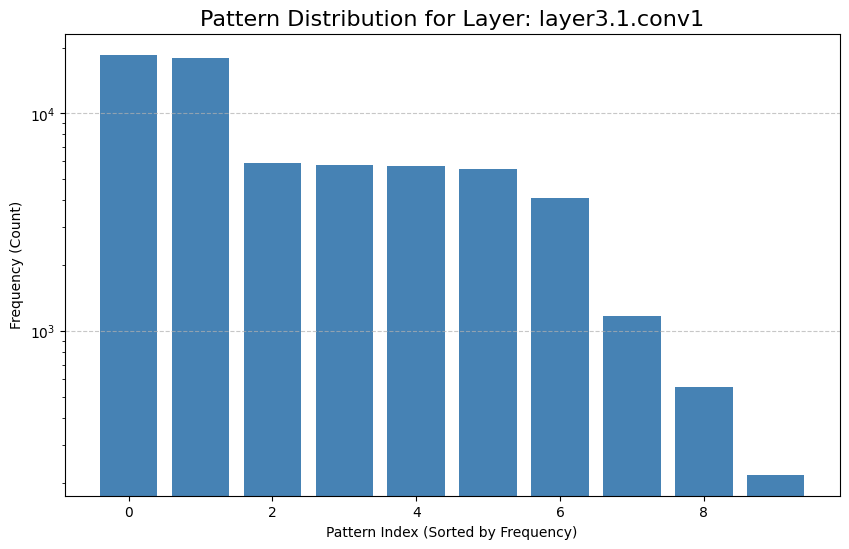

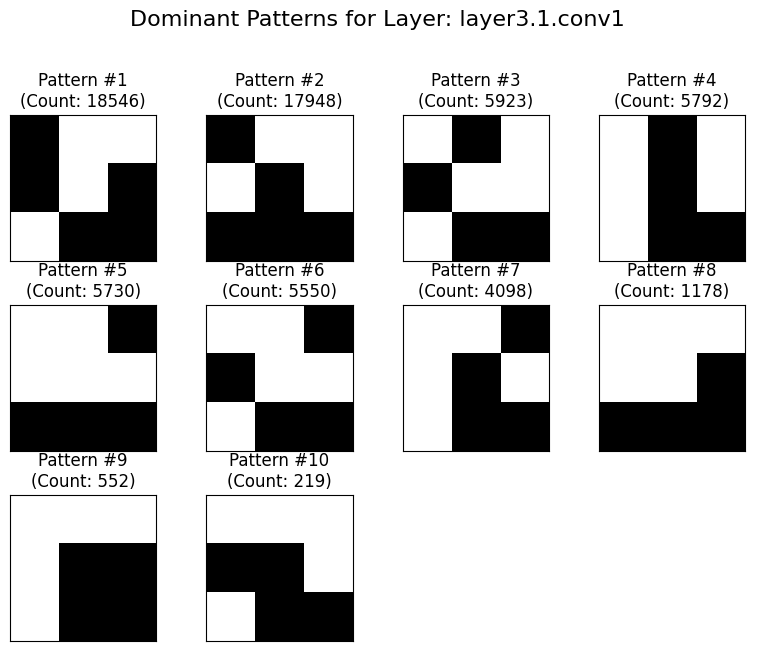

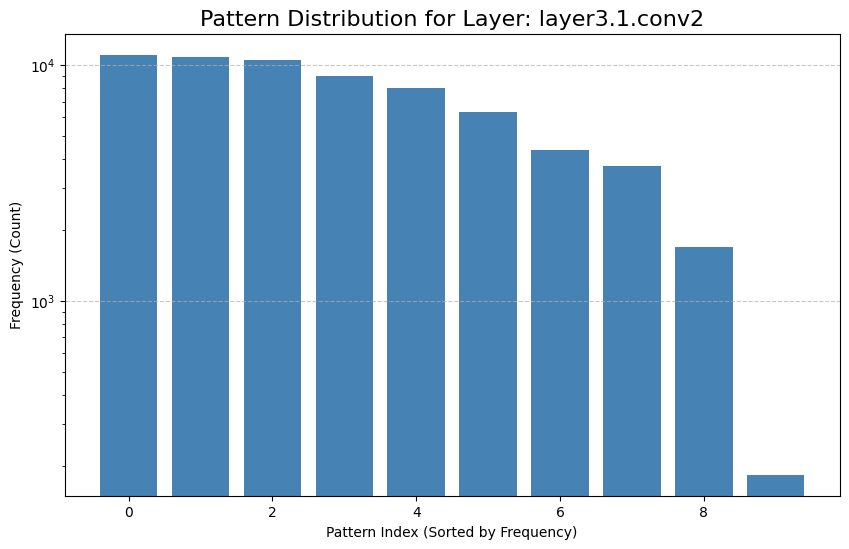

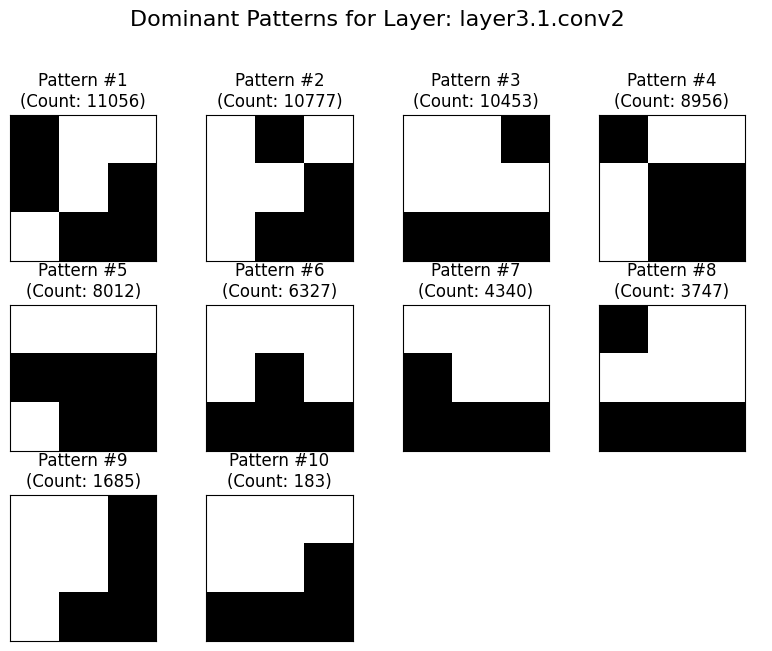

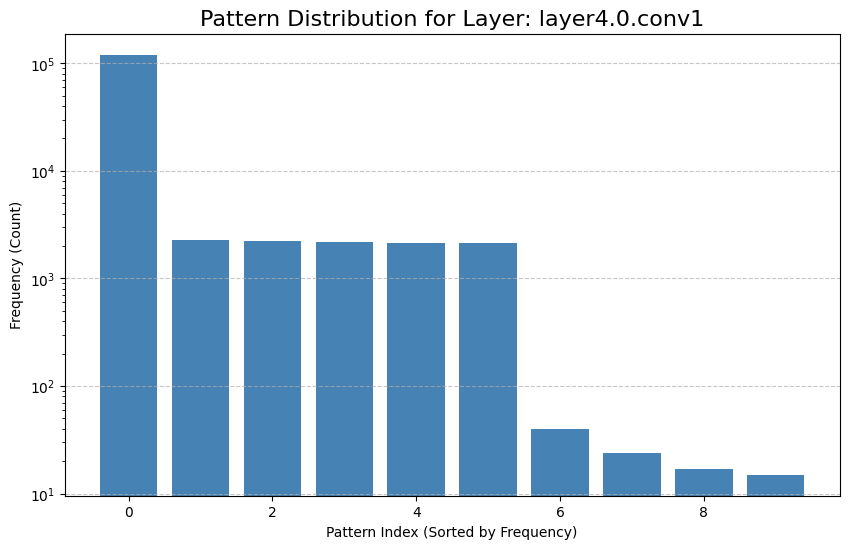

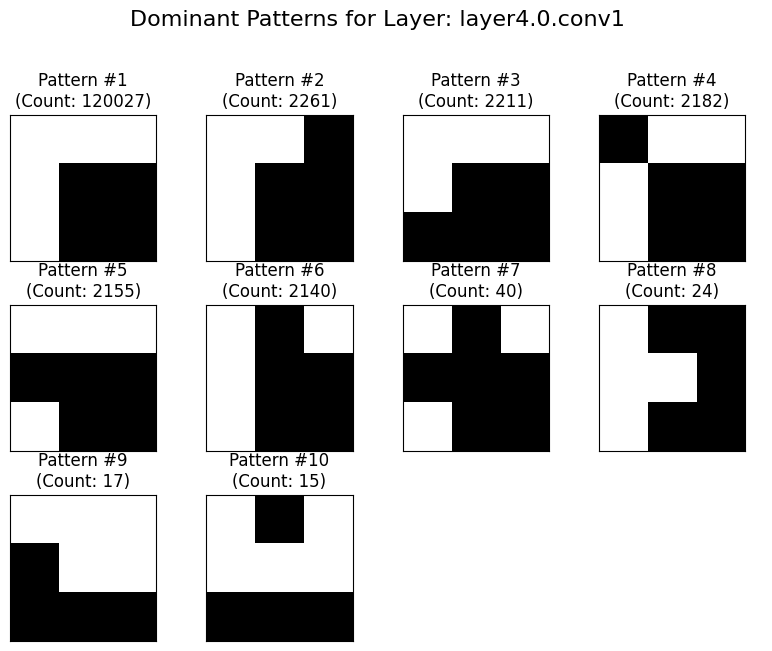

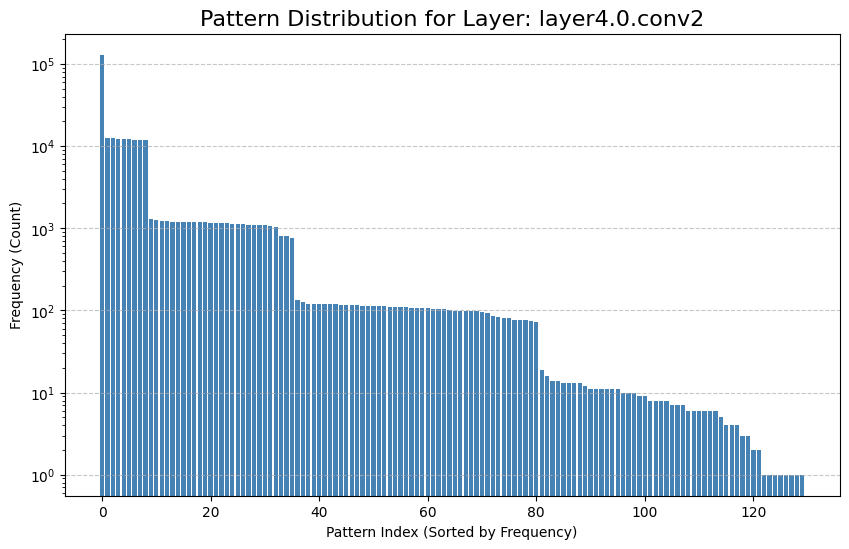

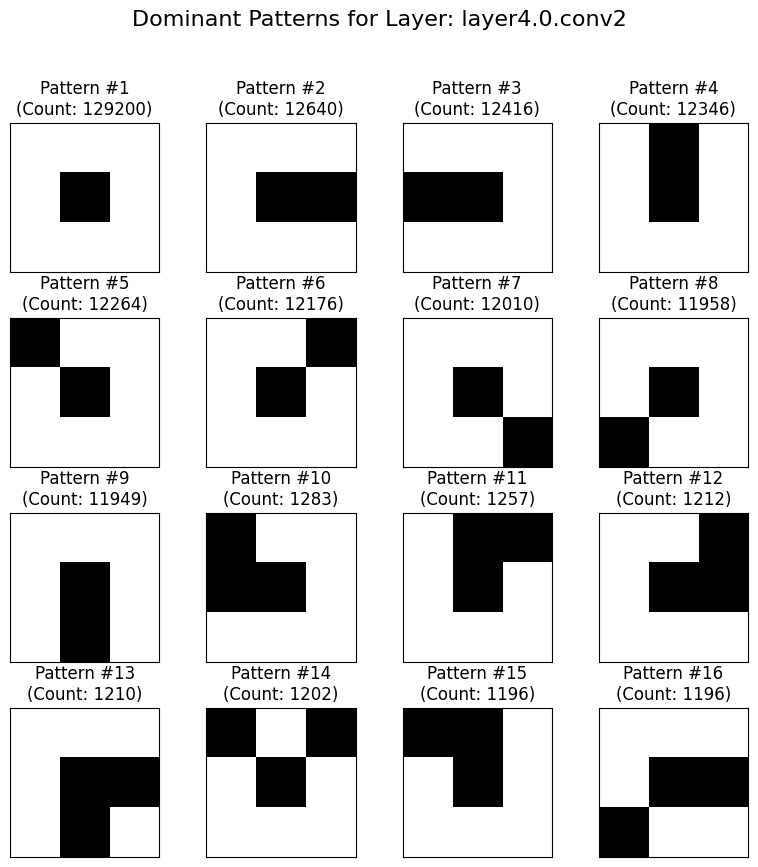

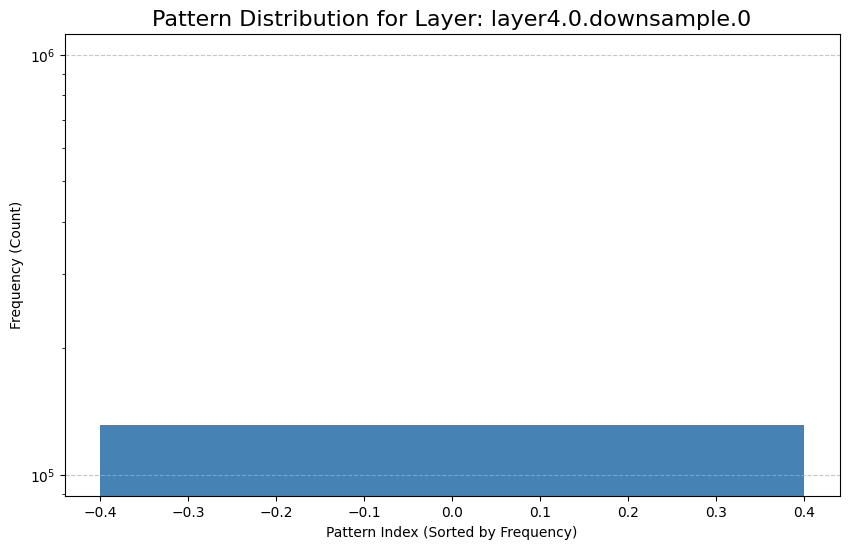

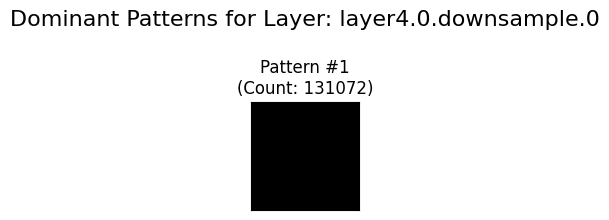

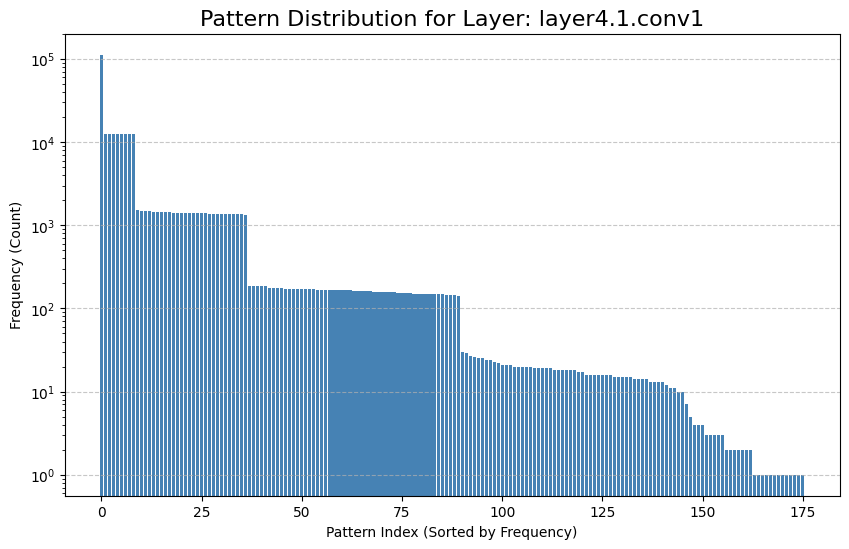

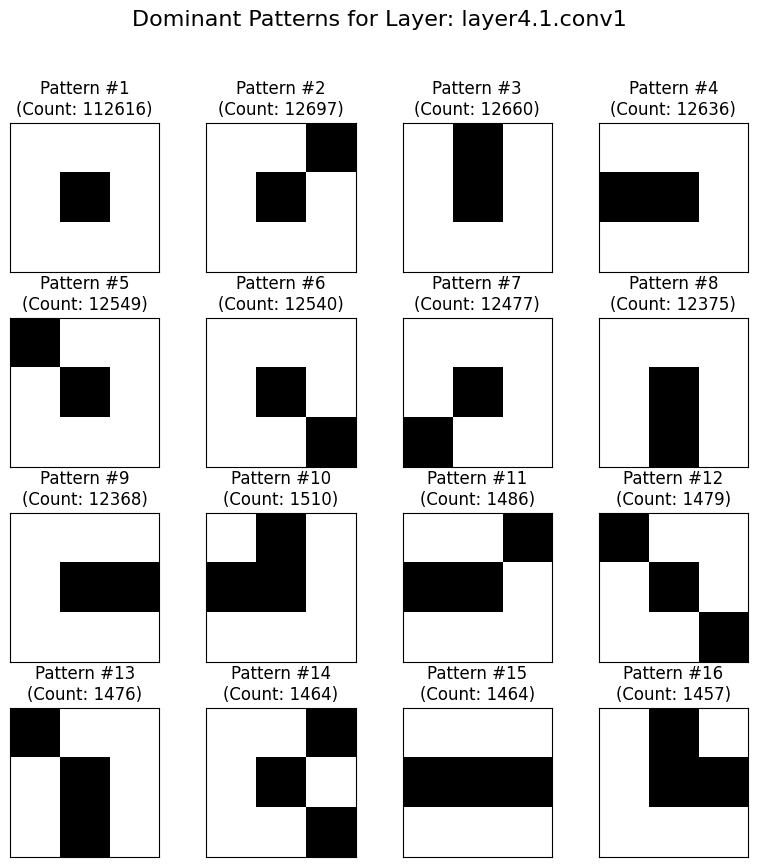

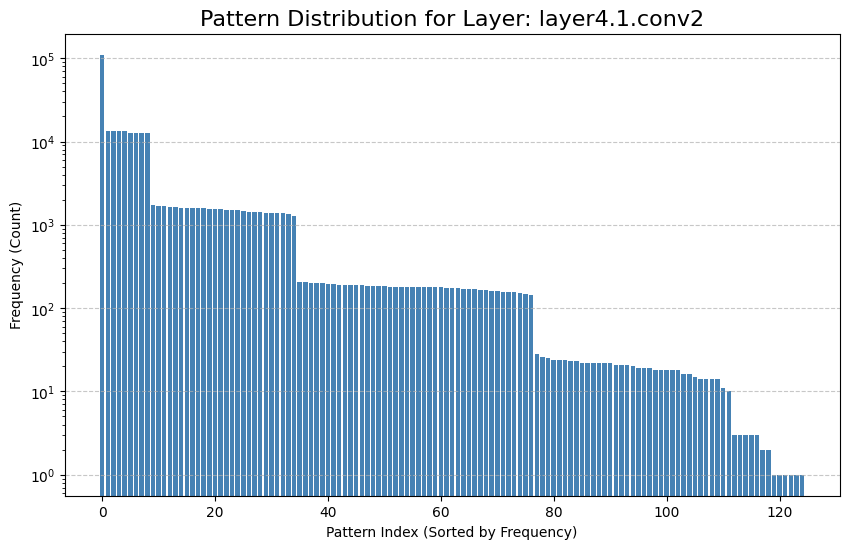

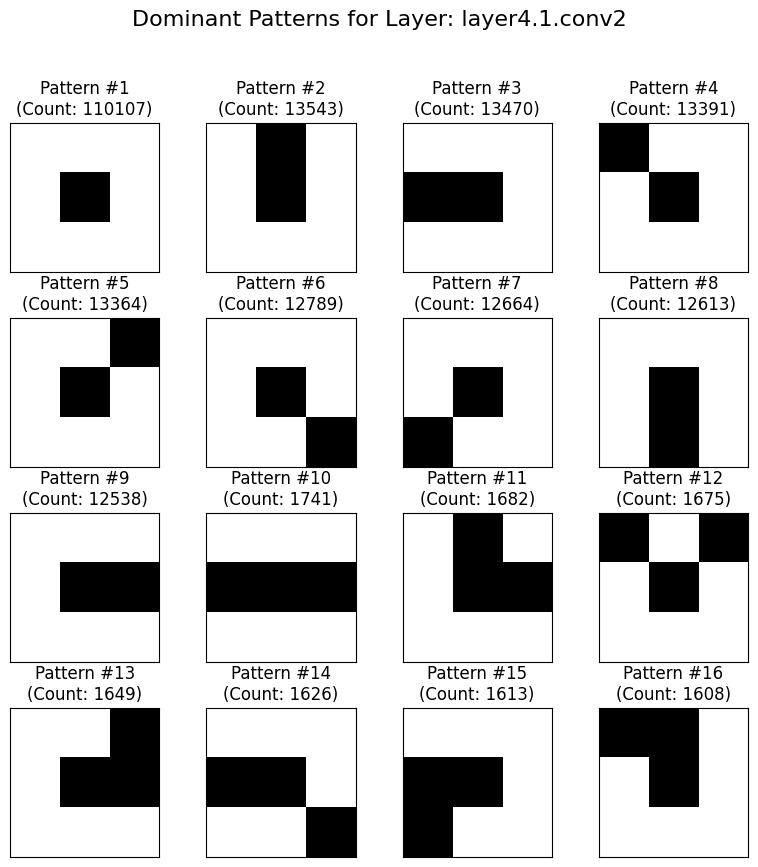

In [28]:

for layer_name, data in all_patterns.items():
    fig_hist = plot_pattern_distribution(layer_name, data)
    plt.show()
    
    fig_patterns = plot_dominant_patterns(layer_name, data)
    plt.show()